<a href="https://colab.research.google.com/github/unipd-human-data/env-soundnet/blob/main/delta_modulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount you Google drive to access the dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/HumanData/utils')

In [4]:
!pip install librosa pydub snntorch tqdm matplotlib torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 3.2 MB/s eta 0:00:00


In [5]:
# Libreria standard
import os                               # file e cartelle
import numpy as np                      # operazioni matriciali, audio e spet sono matrici
import pandas as pd                     # leggere e gestire tabelle come esc50.csv
import matplotlib.pyplot as plt         # grafici std
import seaborn as sns                   # grafici statistici più belli

# Audio
import librosa                          # per audio in python, calcola features ecc
import librosa.display                  # visualizzare spettrogrammi
import torchaudio                       # audio di pytorch, usata per pipeline integrata con PyTorch
import torchaudio.transforms as T       # Moduli per convertire audio in MelSpectogram o trasfromazioni
from pydub import AudioSegment          # gestire audio a livello più "umano"

# Deep learning e SNN
import torch                            # costruzioni reti neurali
import snntorch as snn                  # estensione pytorch per SNN
import snntorch.functional as SF
from snntorch import spikegen           # converte input in spike train
from snntorch import spikeplot as splt
import tensorflow as tf                 # costruzione e training di modelli di ml e dl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from torchinfo import summary
from snntorch import surrogate, functional

# Altri
from tqdm import tqdm                   # aggiungere barre di progresso ai loop, quanto manca al caricamento audio
from torch.utils.data import Dataset    # Dataset class
from torch.utils.data import DataLoader # DataLoader class
from enum import Enum
import time
import itertools
import random
import json
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [6]:
from preprocessing import SAMPLE_RATE, N_MELS, N_FFT, HOP_LENGTH, DURATION
from preprocessing import (
    load_audio_file,
    naa,
    preprocess_audio,
    batch_logmel,
    pad_to_multiple_of,
    preprocess_dataset
)

from spike_encoding import (
    DeltaAudioDataset,
    ThresholdAdaptiveDataset,
    StepForwardDataset,
    visualize_spike_trains
)

from train_eval import (
    train_fn,
    evaluate_model_comprehensive
)

from models import (
    SNNClassifier,
    C_SNN
)

from performance_analysis import (
    PerformanceProfiler,
    run_performance_evaluation
)

In [7]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Save best models

In [9]:
os.makedirs('/content/drive/MyDrive/HumanData/best_models', exist_ok=True)

In [10]:
# Labels ESC-10
class ESCLabels:
    class_names = [
        'chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby', 'dog',
        'helicopter', 'rain', 'rooster', 'sea_waves', 'sneezing'
    ]
    label_to_index = {label: idx for idx, label in enumerate(class_names)}
    index_to_label = {idx: label for label, idx in label_to_index.items()}


In [11]:
BASE_PATH = '/content/drive/MyDrive/HumanData/ESC-10'

In [12]:
X_audio = []
y_labels = []
labels = sorted(os.listdir(BASE_PATH))  # lista classi ordinate
print(labels, "\n")
label_to_index = {label: idx for idx, label in enumerate(labels)}

for label in tqdm(labels, desc="Caricamento Audio"):
    class_path = os.path.join(BASE_PATH, label)
    for file in os.listdir(class_path):
        if file.endswith('.wav'):
            file_path = os.path.join(class_path, file)
            y = load_audio_file(file_path, sr=SAMPLE_RATE, duration=DURATION)
            X_audio.append(y)
            y_labels.append(label_to_index[label])

['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby', 'dog', 'helicopter', 'rain', 'rooster', 'sea_waves', 'sneezing'] 



Caricamento Audio: 100%|██████████| 10/10 [03:36<00:00, 21.63s/it]


In [13]:
X_train, X_temp, y_train, y_temp = train_test_split(X_audio, y_labels, test_size=0.4, random_state=42, stratify=y_labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 240, Val: 80, Test: 80


# Preprocessing



In [14]:
X_train_tensor, y_train_tensor = preprocess_dataset(X_train, y_train, apply_naa=True, apply_taa=False)
X_val_tensor, y_val_tensor = preprocess_dataset(X_val, y_val, apply_naa=False, apply_taa=False)
X_test_tensor, y_test_tensor = preprocess_dataset(X_test, y_test, apply_naa=False, apply_taa=False)

Log-Mel: 100%|██████████| 80/80 [00:00<00:00, 87.06it/s]


Shape verification

In [15]:
print("X_train:", X_train_tensor.shape, "| y_train:", y_train_tensor.shape)
print("X_val:  ", X_val_tensor.shape, "| y_val:  ", y_val_tensor.shape)
print("X_test: ", X_test_tensor.shape, "| y_test: ", y_test_tensor.shape)

X_train: torch.Size([1200, 128, 450, 1]) | y_train: torch.Size([1200])
X_val:   torch.Size([80, 128, 450, 1]) | y_val:   torch.Size([80])
X_test:  torch.Size([80, 128, 450, 1]) | y_test:  torch.Size([80])


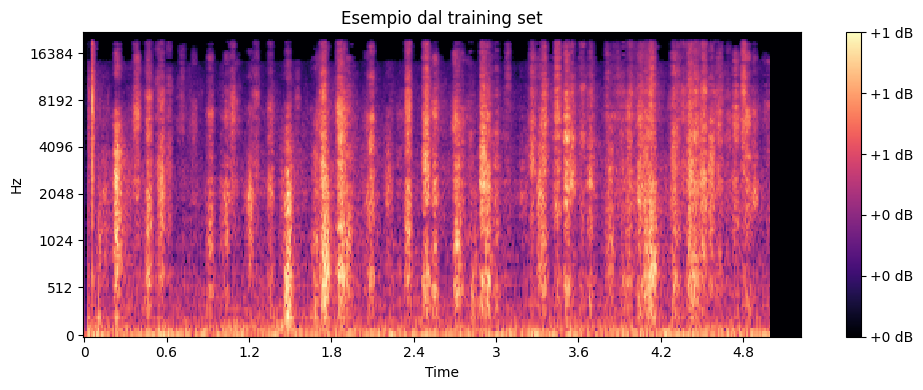

Class: crackling_fire


In [16]:
def show_mel(mel, title="Log-Mel Spectrogram"):
    if isinstance(mel, torch.Tensor):
        mel = mel.squeeze().cpu().numpy()
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()


# Visualizza un esempio a caso dal training set
sample_idx = 32
show_mel(X_train_tensor[sample_idx], title="Esempio dal training set")
print("Class:", ESCLabels.index_to_label[y_train_tensor[sample_idx].item()])


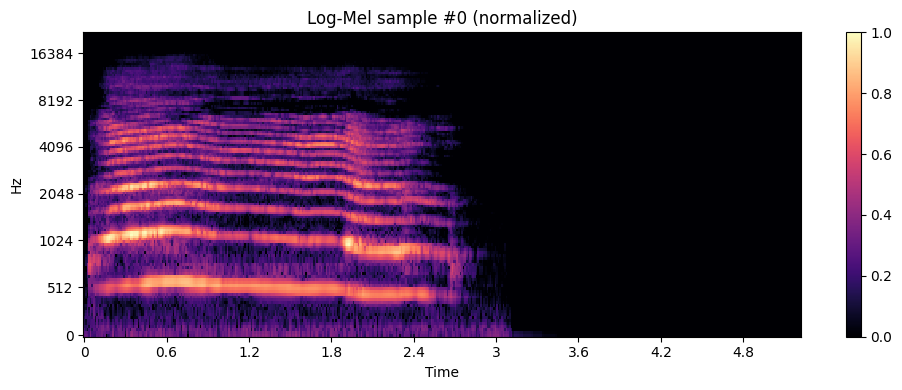

Class: crying_baby


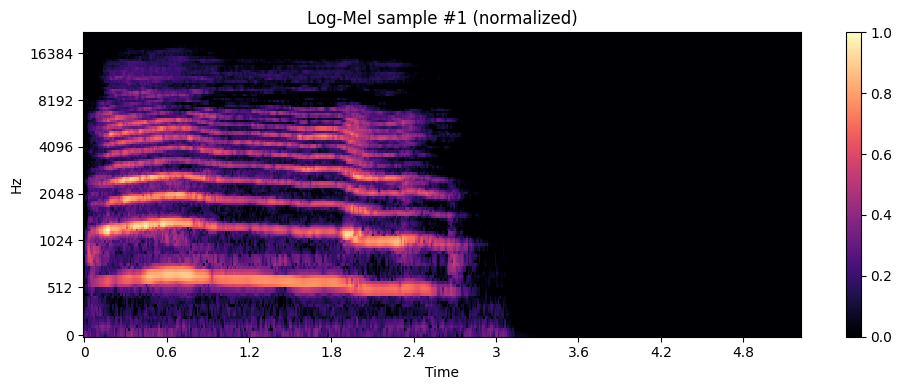

Class: crying_baby


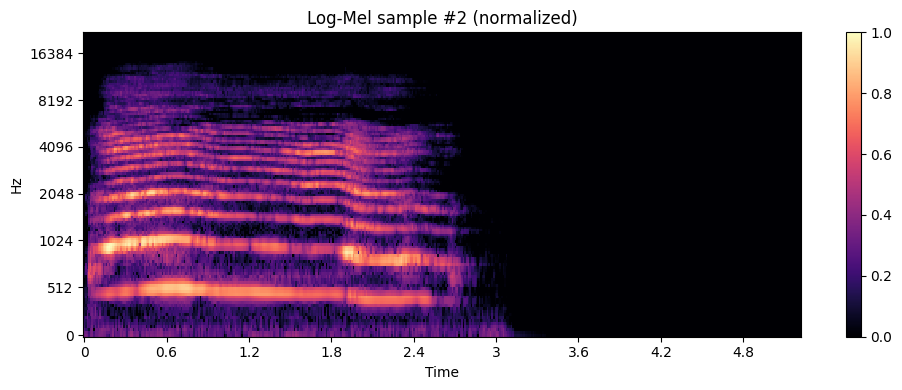

Class: crying_baby


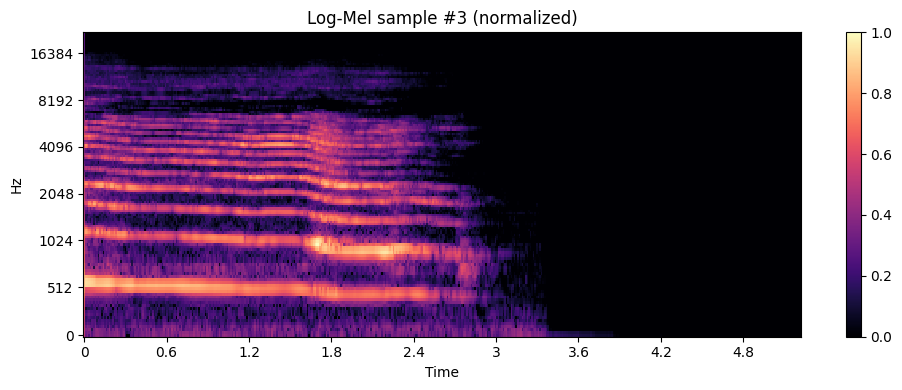

Class: crying_baby


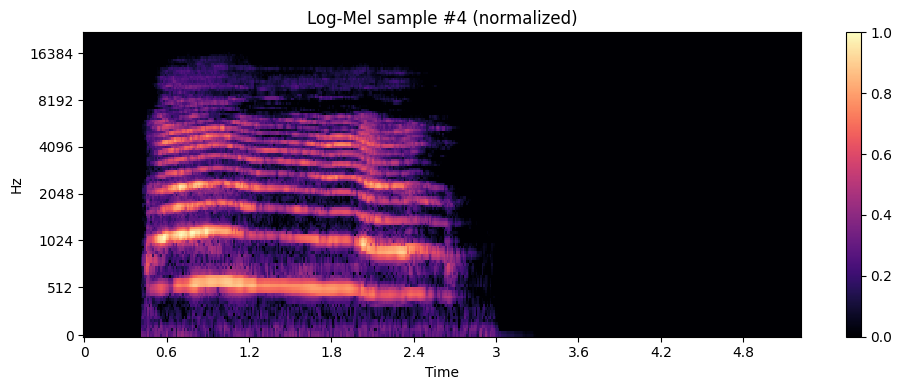

Class: crying_baby


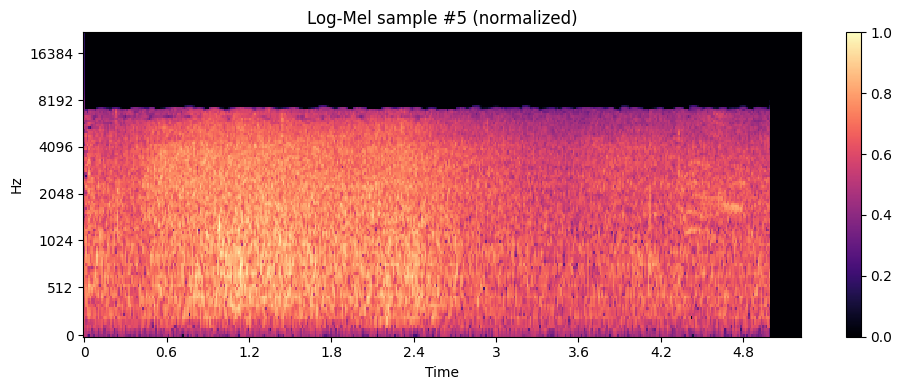

Class: sea_waves


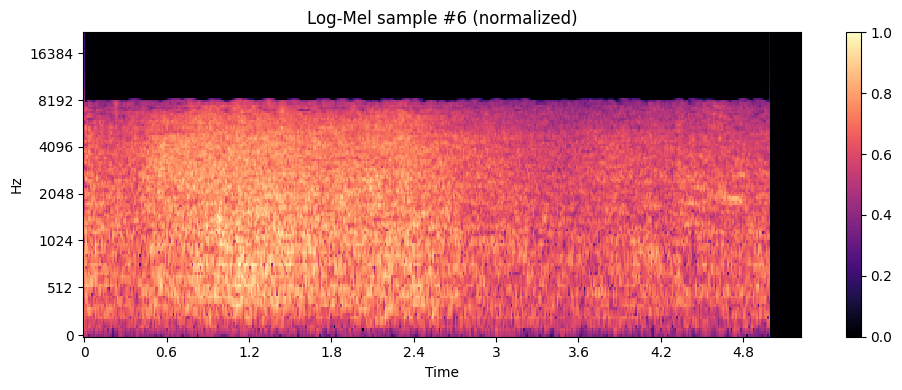

Class: sea_waves


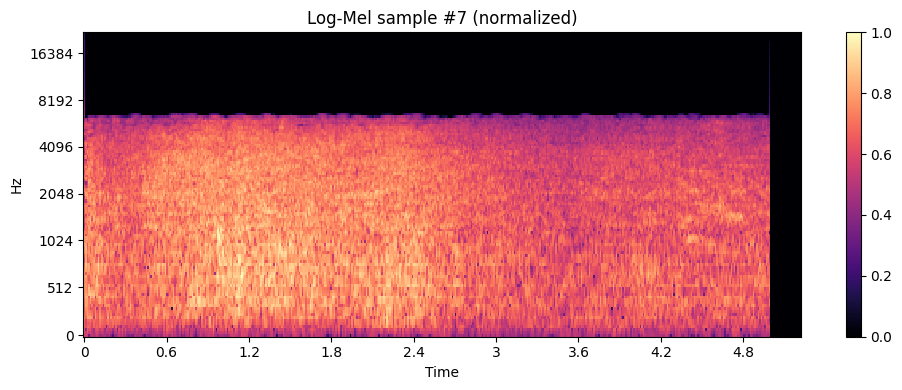

Class: sea_waves


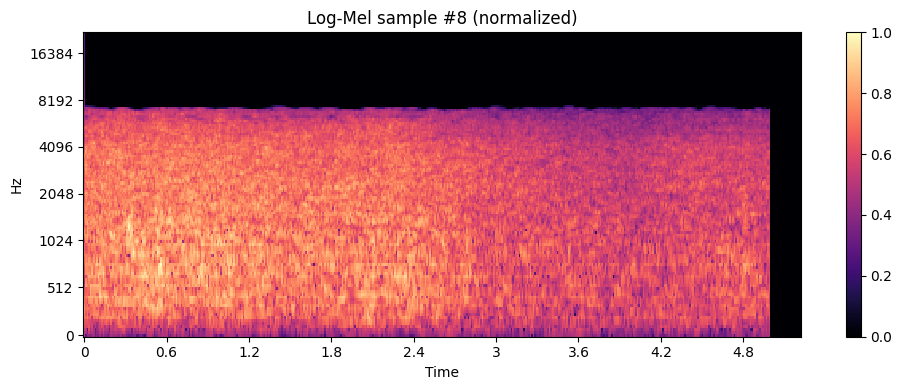

Class: sea_waves


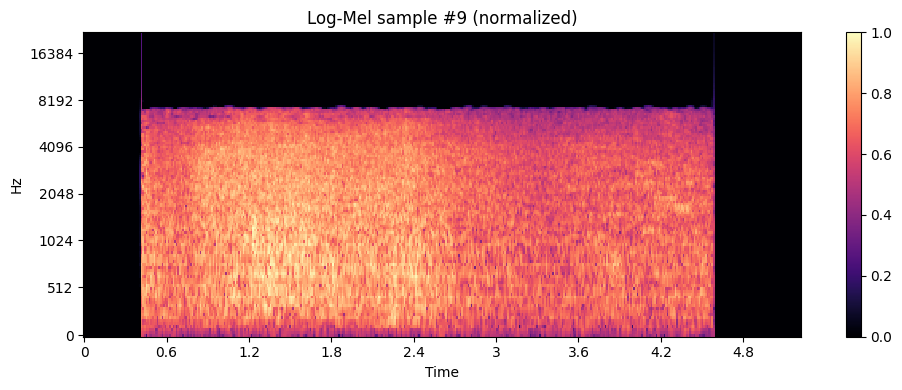

Class: sea_waves


In [17]:
def show_mel_sample(index):
    mel = X_train_tensor[index].numpy().squeeze()  # converti tensore in NumPy
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.colorbar()
    plt.title(f"Log-Mel sample #{index} (normalized)")
    plt.tight_layout()
    plt.show()
    print("Class:", ESCLabels.index_to_label[y_train_tensor[index].item()])

for i in range(10):
    show_mel_sample(i)

#Parameters for training:

In [18]:
patience = 30
num_epochs = 100
hidden_sizes = [128, 128, 128]
num_classes = 10
BATCH_SIZE = 32

# Spike Encoding: Delta Modulation

In [19]:
THRESHOLD = 0.05
TIMESTEPS = 200

In [20]:
delta_train_dataset = DeltaAudioDataset(X_train_tensor, y_train_tensor, threshold=THRESHOLD, timesteps=TIMESTEPS)
delta_val_dataset = DeltaAudioDataset(X_val_tensor, y_val_tensor, threshold=THRESHOLD, timesteps=TIMESTEPS)
delta_test_dataset = DeltaAudioDataset(X_test_tensor, y_test_tensor, threshold=THRESHOLD, timesteps=TIMESTEPS)

In [21]:
delta_train_loader = DataLoader(delta_train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                num_workers=2, pin_memory=torch.cuda.is_available())
delta_val_loader = DataLoader(delta_val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=2, pin_memory=torch.cuda.is_available())
delta_test_loader = DataLoader(delta_test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                               num_workers=2, pin_memory=torch.cuda.is_available())

In [22]:
delta_X_batch, delta_y_batch = next(iter(delta_train_loader))
print("DeltaModulation encoding compleated!")

DeltaModulation encoding compleated!


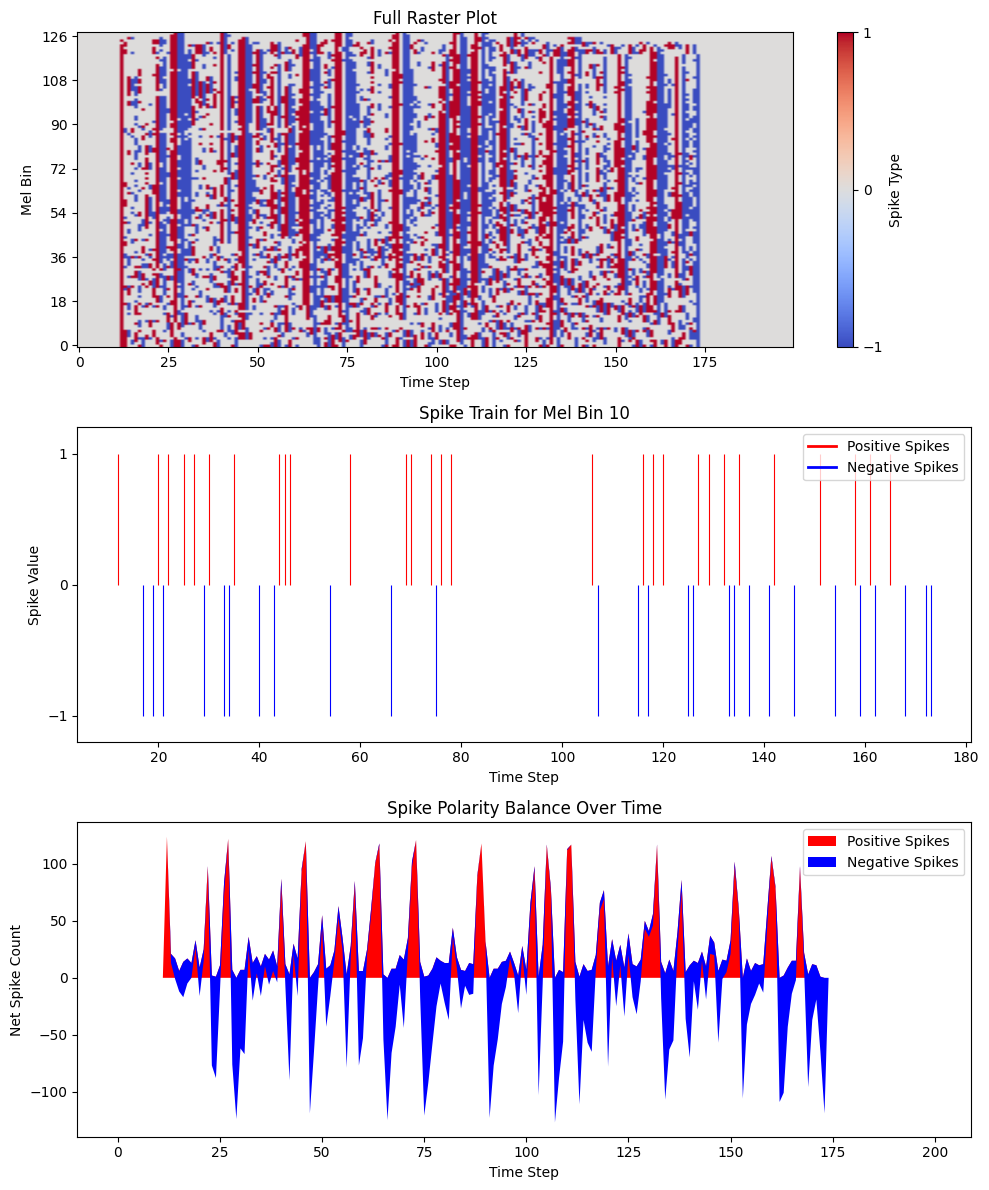

Delta Class: crackling_fire


In [23]:
sample_idx = 10
visualize_spike_trains(delta_X_batch, sample_idx=sample_idx, mel_bin=10)
print(f"Delta Class: {ESCLabels.index_to_label[delta_y_batch[sample_idx].item()]}")

##Delta Modulation: SNN training

In [42]:
delta_snn_classifier = SNNClassifier(
    n_mels=N_MELS,
    hidden_sizes=hidden_sizes,
    num_classes=num_classes,
    surr_grad=snn.surrogate.fast_sigmoid(),
    learn_thr=True,
    learn_beta=True
).to(device)

summary(delta_snn_classifier, input_size=(32, 1, N_MELS))

Layer (type:depth-idx)                   Output Shape              Param #
SNNClassifier                            [1, 32, 10]               --
├─Linear: 1-1                            [32, 128]                 16,512
├─Leaky: 1-2                             [32, 128]                 129
├─Linear: 1-3                            [32, 128]                 16,512
├─Leaky: 1-4                             [32, 128]                 129
├─Linear: 1-5                            [32, 128]                 16,512
├─Leaky: 1-6                             [32, 128]                 129
├─Linear: 1-7                            [32, 10]                  1,290
├─Leaky: 1-8                             [32, 10]                  11
Total params: 51,224
Trainable params: 51,224
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.63
Input size (MB): 0.02
Forward/backward pass size (MB): 0.20
Params size (MB): 0.20
Estimated Total Size (MB): 0.42

In [43]:
optimizer = torch.optim.Adam(delta_snn_classifier.parameters(), lr=0.001)

train_loss, train_acc, val_loss, val_acc = train_fn(
    model=delta_snn_classifier,
    train_loader=delta_train_loader,
    valid_loader=delta_val_loader,
    accuracy=SF.acc.accuracy_rate,
    loss_fn=snn.functional.ce_count_loss(),
    optimizer=optimizer,
    epochs=num_epochs,
    patience=patience,
    path="./",
    device=device,
    verbose=True
)

Epochs:   1%|          | 1/100 [00:46<1:16:19, 46.25s/it]


Epoch 1/100 - 46s - loss: 2.3026 - acc: 0.1012 - val_loss: 2.3026 - val_acc: 0.0938



Epochs:   2%|▏         | 2/100 [01:29<1:12:33, 44.43s/it]


Epoch 2/100 - 43s - loss: 2.3026 - acc: 0.1003 - val_loss: 2.3026 - val_acc: 0.0938



Epochs:   3%|▎         | 3/100 [02:17<1:14:36, 46.15s/it]


Epoch 3/100 - 48s - loss: 2.3026 - acc: 0.0987 - val_loss: 2.3026 - val_acc: 0.0938



Epochs:   4%|▍         | 4/100 [03:00<1:11:44, 44.84s/it]


Epoch 4/100 - 42s - loss: 2.3165 - acc: 0.1102 - val_loss: 2.2413 - val_acc: 0.1354



Epochs:   5%|▌         | 5/100 [03:44<1:10:30, 44.54s/it]


Epoch 5/100 - 43s - loss: 2.3046 - acc: 0.1373 - val_loss: 2.4673 - val_acc: 0.2396



Epochs:   6%|▌         | 6/100 [04:27<1:08:45, 43.89s/it]


Epoch 6/100 - 42s - loss: 2.3059 - acc: 0.1423 - val_loss: 2.2479 - val_acc: 0.1458



Epochs:   7%|▋         | 7/100 [05:10<1:07:42, 43.69s/it]


Epoch 7/100 - 43s - loss: 2.1983 - acc: 0.1760 - val_loss: 2.1825 - val_acc: 0.1562



Epochs:   8%|▊         | 8/100 [05:53<1:06:31, 43.38s/it]


Epoch 8/100 - 42s - loss: 2.1142 - acc: 0.1998 - val_loss: 1.9800 - val_acc: 0.2604



Epochs:   9%|▉         | 9/100 [06:36<1:05:41, 43.31s/it]


Epoch 9/100 - 43s - loss: 2.1739 - acc: 0.2220 - val_loss: 2.0391 - val_acc: 0.2500



Epochs:  10%|█         | 10/100 [07:18<1:04:42, 43.14s/it]


Epoch 10/100 - 42s - loss: 1.9713 - acc: 0.3002 - val_loss: 2.1993 - val_acc: 0.3542



Epochs:  11%|█         | 11/100 [08:04<1:05:04, 43.87s/it]


Epoch 11/100 - 45s - loss: 1.9966 - acc: 0.3495 - val_loss: 2.5655 - val_acc: 0.2917



Epochs:  12%|█▏        | 12/100 [08:46<1:03:43, 43.44s/it]


Epoch 12/100 - 42s - loss: 2.0876 - acc: 0.3413 - val_loss: 2.5909 - val_acc: 0.2917



Epochs:  13%|█▎        | 13/100 [09:30<1:02:54, 43.38s/it]


Epoch 13/100 - 43s - loss: 1.9954 - acc: 0.3791 - val_loss: 3.0716 - val_acc: 0.3021



Epochs:  14%|█▍        | 14/100 [10:12<1:01:52, 43.16s/it]


Epoch 14/100 - 42s - loss: 1.8025 - acc: 0.4252 - val_loss: 2.4444 - val_acc: 0.3229



Epochs:  15%|█▌        | 15/100 [10:55<1:00:56, 43.01s/it]


Epoch 15/100 - 42s - loss: 1.5731 - acc: 0.4457 - val_loss: 2.3015 - val_acc: 0.4375



Epochs:  16%|█▌        | 16/100 [11:38<1:00:19, 43.09s/it]


Epoch 16/100 - 43s - loss: 1.5563 - acc: 0.4383 - val_loss: 2.0145 - val_acc: 0.4271



Epochs:  17%|█▋        | 17/100 [12:21<59:31, 43.03s/it]  


Epoch 17/100 - 42s - loss: 1.6202 - acc: 0.4572 - val_loss: 2.1362 - val_acc: 0.3854



Epochs:  18%|█▊        | 18/100 [13:04<58:52, 43.08s/it]


Epoch 18/100 - 43s - loss: 1.4279 - acc: 0.4901 - val_loss: 1.9591 - val_acc: 0.5000



Epochs:  19%|█▉        | 19/100 [13:47<58:03, 43.01s/it]


Epoch 19/100 - 42s - loss: 1.3572 - acc: 0.5049 - val_loss: 2.3289 - val_acc: 0.4479



Epochs:  20%|██        | 20/100 [14:31<57:35, 43.19s/it]


Epoch 20/100 - 43s - loss: 1.2841 - acc: 0.5395 - val_loss: 1.9608 - val_acc: 0.4896



Epochs:  21%|██        | 21/100 [15:14<56:47, 43.13s/it]


Epoch 21/100 - 42s - loss: 1.1373 - acc: 0.5847 - val_loss: 1.7868 - val_acc: 0.4688



Epochs:  22%|██▏       | 22/100 [15:58<56:17, 43.30s/it]


Epoch 22/100 - 43s - loss: 1.1367 - acc: 0.5979 - val_loss: 2.0555 - val_acc: 0.4375



Epochs:  23%|██▎       | 23/100 [16:41<55:38, 43.36s/it]


Epoch 23/100 - 43s - loss: 1.0420 - acc: 0.6192 - val_loss: 2.0315 - val_acc: 0.3958



Epochs:  24%|██▍       | 24/100 [17:25<55:01, 43.44s/it]


Epoch 24/100 - 43s - loss: 0.9888 - acc: 0.6316 - val_loss: 1.9790 - val_acc: 0.4062



Epochs:  25%|██▌       | 25/100 [18:08<54:05, 43.28s/it]


Epoch 25/100 - 42s - loss: 0.9963 - acc: 0.6414 - val_loss: 2.1729 - val_acc: 0.4583



Epochs:  26%|██▌       | 26/100 [18:51<53:30, 43.38s/it]


Epoch 26/100 - 43s - loss: 0.9424 - acc: 0.6587 - val_loss: 1.6714 - val_acc: 0.5625



Epochs:  27%|██▋       | 27/100 [19:34<52:43, 43.34s/it]


Epoch 27/100 - 43s - loss: 0.8216 - acc: 0.6941 - val_loss: 1.4219 - val_acc: 0.5729



Epochs:  28%|██▊       | 28/100 [20:18<52:07, 43.44s/it]


Epoch 28/100 - 43s - loss: 0.7931 - acc: 0.7007 - val_loss: 1.8072 - val_acc: 0.4688



Epochs:  29%|██▉       | 29/100 [21:01<51:13, 43.29s/it]


Epoch 29/100 - 42s - loss: 0.6884 - acc: 0.7237 - val_loss: 2.1538 - val_acc: 0.4375



Epochs:  30%|███       | 30/100 [21:44<50:27, 43.25s/it]


Epoch 30/100 - 43s - loss: 0.6915 - acc: 0.7336 - val_loss: 2.8233 - val_acc: 0.4271



Epochs:  31%|███       | 31/100 [22:28<50:04, 43.55s/it]


Epoch 31/100 - 44s - loss: 0.7337 - acc: 0.7451 - val_loss: 1.5848 - val_acc: 0.5521



Epochs:  32%|███▏      | 32/100 [23:12<49:17, 43.49s/it]


Epoch 32/100 - 43s - loss: 0.6397 - acc: 0.7516 - val_loss: 1.9341 - val_acc: 0.5417



Epochs:  33%|███▎      | 33/100 [23:56<48:47, 43.70s/it]


Epoch 33/100 - 44s - loss: 0.6161 - acc: 0.7689 - val_loss: 2.4764 - val_acc: 0.4688



Epochs:  34%|███▍      | 34/100 [24:39<47:55, 43.56s/it]


Epoch 34/100 - 43s - loss: 0.5959 - acc: 0.7697 - val_loss: 2.5643 - val_acc: 0.5312



Epochs:  35%|███▌      | 35/100 [25:23<47:19, 43.69s/it]


Epoch 35/100 - 43s - loss: 0.5203 - acc: 0.8026 - val_loss: 2.3232 - val_acc: 0.5521



Epochs:  36%|███▌      | 36/100 [26:06<46:22, 43.47s/it]


Epoch 36/100 - 42s - loss: 0.5197 - acc: 0.7952 - val_loss: 2.7557 - val_acc: 0.5521



Epochs:  37%|███▋      | 37/100 [26:50<45:48, 43.63s/it]


Epoch 37/100 - 43s - loss: 0.4743 - acc: 0.8240 - val_loss: 2.0257 - val_acc: 0.5938



Epochs:  38%|███▊      | 38/100 [27:33<44:51, 43.40s/it]


Epoch 38/100 - 42s - loss: 0.4253 - acc: 0.8224 - val_loss: 1.4800 - val_acc: 0.6250



Epochs:  39%|███▉      | 39/100 [28:17<44:24, 43.67s/it]


Epoch 39/100 - 44s - loss: 0.4402 - acc: 0.8207 - val_loss: 1.7168 - val_acc: 0.6146



Epochs:  40%|████      | 40/100 [29:01<43:32, 43.54s/it]


Epoch 40/100 - 43s - loss: 0.5080 - acc: 0.8051 - val_loss: 2.6463 - val_acc: 0.5625



Epochs:  41%|████      | 41/100 [29:44<42:42, 43.43s/it]


Epoch 41/100 - 43s - loss: 0.4233 - acc: 0.8322 - val_loss: 1.7185 - val_acc: 0.6146



Epochs:  42%|████▏     | 42/100 [30:27<41:59, 43.44s/it]


Epoch 42/100 - 43s - loss: 0.3757 - acc: 0.8610 - val_loss: 1.8535 - val_acc: 0.5625



Epochs:  43%|████▎     | 43/100 [31:10<41:09, 43.33s/it]


Epoch 43/100 - 43s - loss: 0.3970 - acc: 0.8405 - val_loss: 1.8967 - val_acc: 0.5833



Epochs:  44%|████▍     | 44/100 [31:54<40:25, 43.30s/it]


Epoch 44/100 - 43s - loss: 0.3744 - acc: 0.8561 - val_loss: 2.7382 - val_acc: 0.4792



Epochs:  45%|████▌     | 45/100 [32:36<39:34, 43.16s/it]


Epoch 45/100 - 42s - loss: 0.3593 - acc: 0.8635 - val_loss: 2.5072 - val_acc: 0.5521



Epochs:  46%|████▌     | 46/100 [33:20<38:55, 43.25s/it]


Epoch 46/100 - 43s - loss: 0.2798 - acc: 0.8931 - val_loss: 1.8453 - val_acc: 0.6458



Epochs:  47%|████▋     | 47/100 [34:03<38:06, 43.14s/it]


Epoch 47/100 - 42s - loss: 0.2718 - acc: 0.8947 - val_loss: 2.0532 - val_acc: 0.5417



Epochs:  48%|████▊     | 48/100 [34:46<37:32, 43.32s/it]


Epoch 48/100 - 43s - loss: 0.2873 - acc: 0.8890 - val_loss: 1.9332 - val_acc: 0.5521



Epochs:  49%|████▉     | 49/100 [35:30<36:46, 43.27s/it]


Epoch 49/100 - 43s - loss: 0.3078 - acc: 0.8980 - val_loss: 2.9697 - val_acc: 0.5104



Epochs:  50%|█████     | 50/100 [36:14<36:18, 43.56s/it]


Epoch 50/100 - 44s - loss: 0.3904 - acc: 0.8470 - val_loss: 2.6760 - val_acc: 0.5417



Epochs:  51%|█████     | 51/100 [36:57<35:28, 43.44s/it]


Epoch 51/100 - 43s - loss: 0.2613 - acc: 0.8923 - val_loss: 2.0474 - val_acc: 0.5833



Epochs:  52%|█████▏    | 52/100 [37:41<34:52, 43.60s/it]


Epoch 52/100 - 43s - loss: 0.2627 - acc: 0.8939 - val_loss: 2.7169 - val_acc: 0.5417



Epochs:  53%|█████▎    | 53/100 [38:24<33:57, 43.36s/it]


Epoch 53/100 - 42s - loss: 0.3067 - acc: 0.8956 - val_loss: 2.6745 - val_acc: 0.5417



Epochs:  54%|█████▍    | 54/100 [39:07<33:18, 43.44s/it]


Epoch 54/100 - 43s - loss: 0.2695 - acc: 0.9030 - val_loss: 1.8448 - val_acc: 0.6458



Epochs:  55%|█████▌    | 55/100 [39:51<32:30, 43.35s/it]


Epoch 55/100 - 43s - loss: 0.2716 - acc: 0.9038 - val_loss: 1.7208 - val_acc: 0.6146



Epochs:  56%|█████▌    | 56/100 [40:35<31:58, 43.60s/it]


Epoch 56/100 - 44s - loss: 0.2736 - acc: 0.8923 - val_loss: 2.3659 - val_acc: 0.5833



Epochs:  56%|█████▌    | 56/100 [41:18<32:27, 44.26s/it]

Early stopping triggered


In [26]:
torch.save(delta_snn_classifier.state_dict(), '/content/drive/MyDrive/HumanData/best_models/delta_modulation/delta_snn.pth')

##Delta Modulation: SNN evaluation

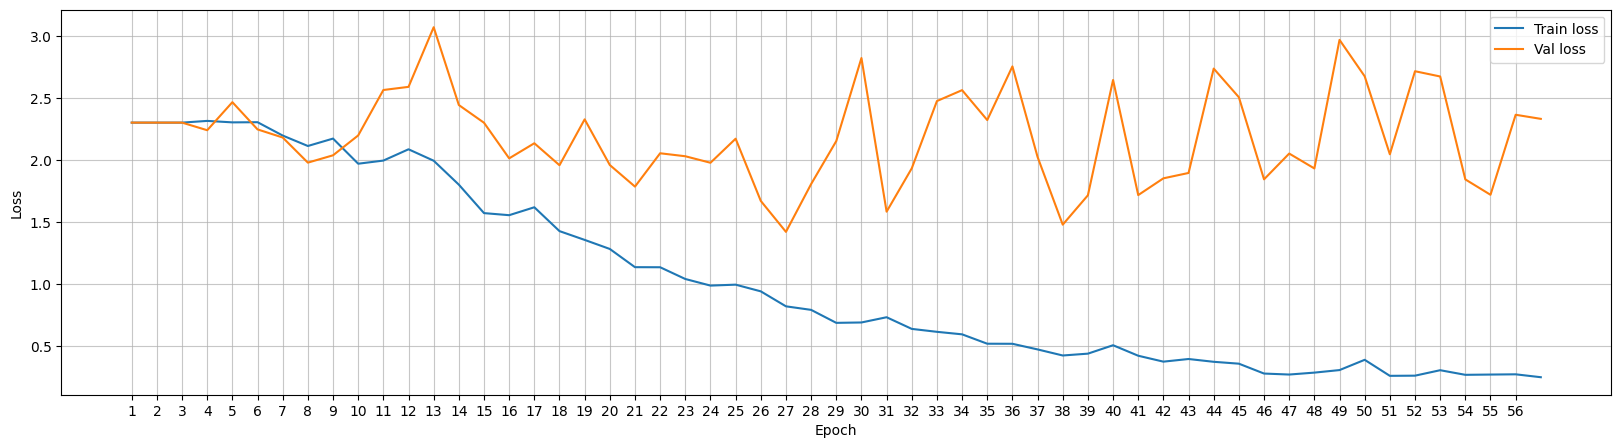

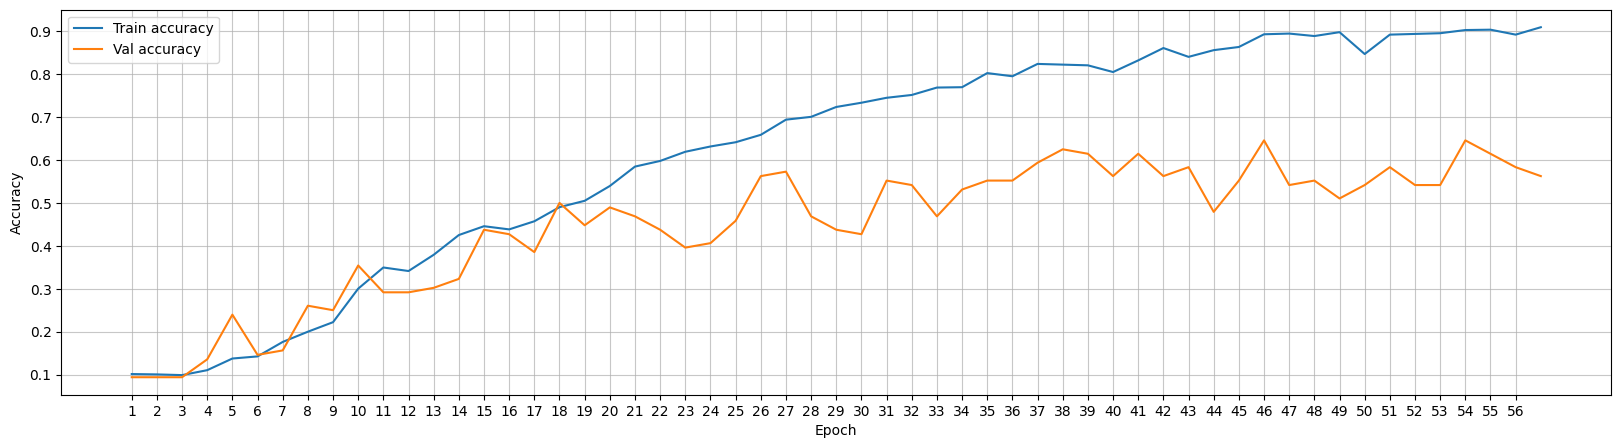

In [44]:
# Plot loss
plt.figure(figsize=(20,5))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Val loss')
plt.xticks(np.arange(1, len(train_loss)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=.7)
plt.legend()

# Plot accuracy
plt.figure(figsize=(20,5))
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train accuracy')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Val accuracy')
plt.xticks(np.arange(1, len(train_acc)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=.7)
plt.legend()
plt.show()

COMPREHENSIVE EVALUATION RESULTS
Accuracy: 0.6000 (60.00%)

MACRO AVERAGES:
  F1-Score   : 0.5676
  Precision  : 0.5938
  Recall     : 0.6000

WEIGHTED AVERAGES:
  F1-Score   : 0.5676
  Precision  : 0.5938
  Recall     : 0.6000

PER-CLASS METRICS:
------------------------------------------------------------
Class           F1       Precision  Recall  
------------------------------------------------------------
chainsaw        0.6000   0.5000     0.7500  
clock_tick      0.2000   0.5000     0.1250  
crackling_fire  0.7273   0.5714     1.0000  
crying_baby     0.8000   0.6667     1.0000  
dog             0.7143   0.8333     0.6250  
helicopter      0.2857   0.3333     0.2500  
rain            0.2857   0.3333     0.2500  
rooster         0.7143   0.8333     0.6250  
sea_waves       0.5714   0.6667     0.5000  
sneezing        0.7778   0.7000     0.8750  

DETAILED CLASSIFICATION REPORT
                precision    recall  f1-score   support

      chainsaw     0.5000    0.7500    0.6000 

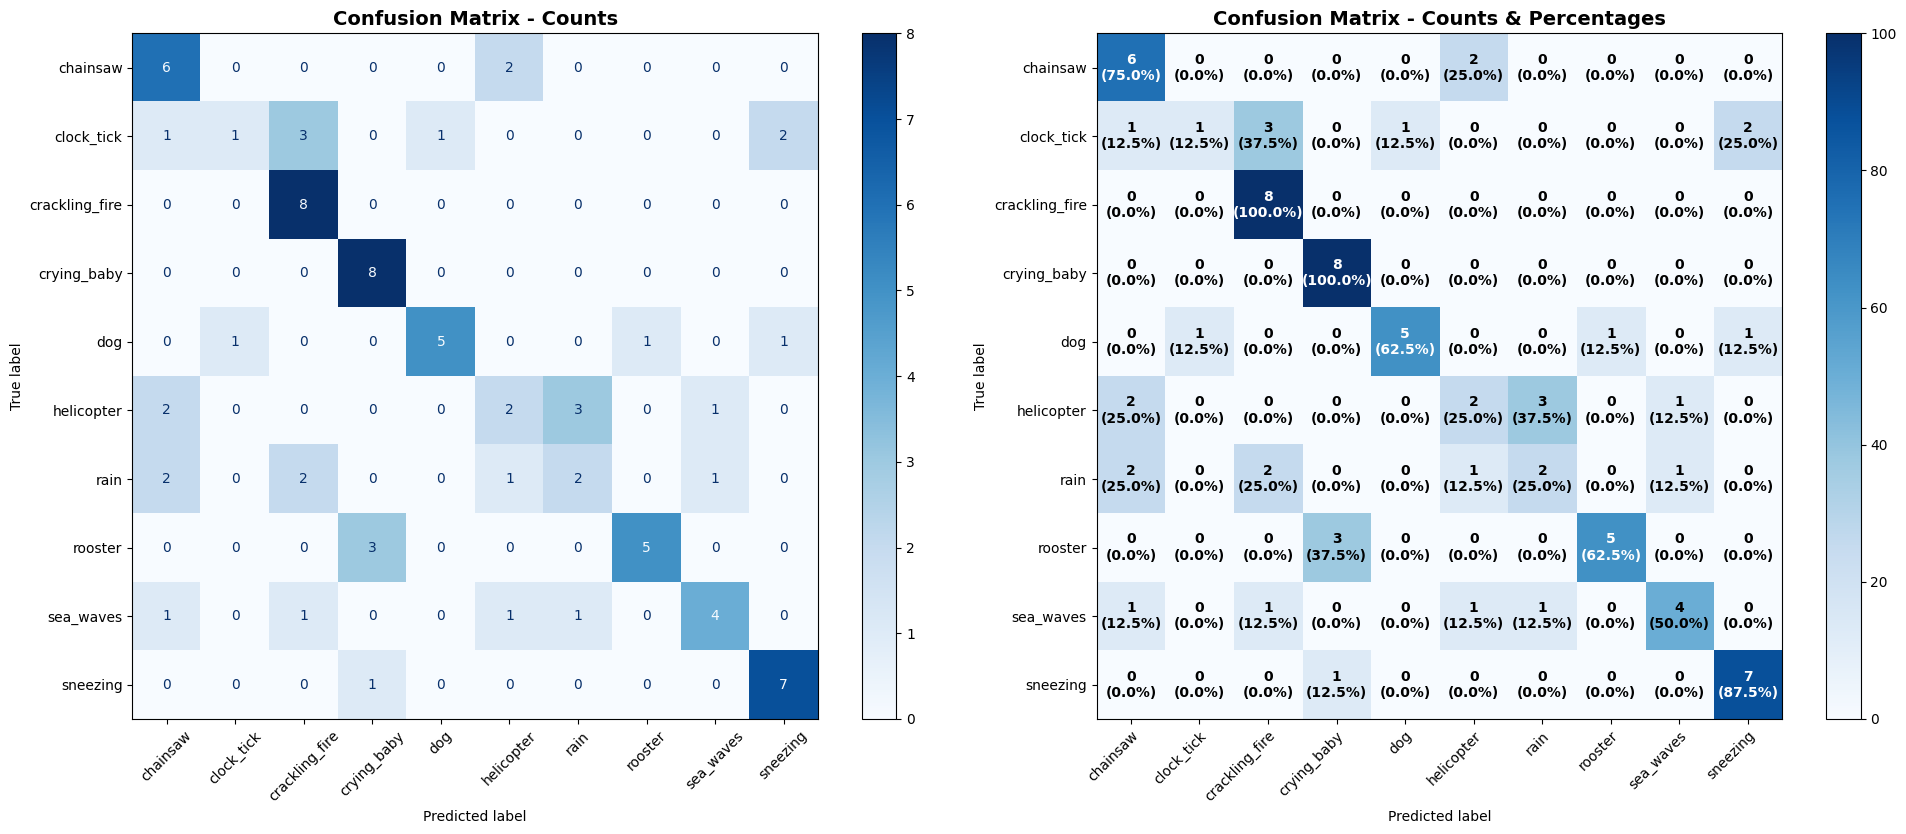


PER-CLASS ACCURACY BREAKDOWN
True Class      Correct  Total    Accuracy  
------------------------------------------------------------
chainsaw        6        8        75.00     %
clock_tick      1        8        12.50     %
crackling_fire  8        8        100.00    %
crying_baby     8        8        100.00    %
dog             5        8        62.50     %
helicopter      2        8        25.00     %
rain            2        8        25.00     %
rooster         5        8        62.50     %
sea_waves       4        8        50.00     %
sneezing        7        8        87.50     %


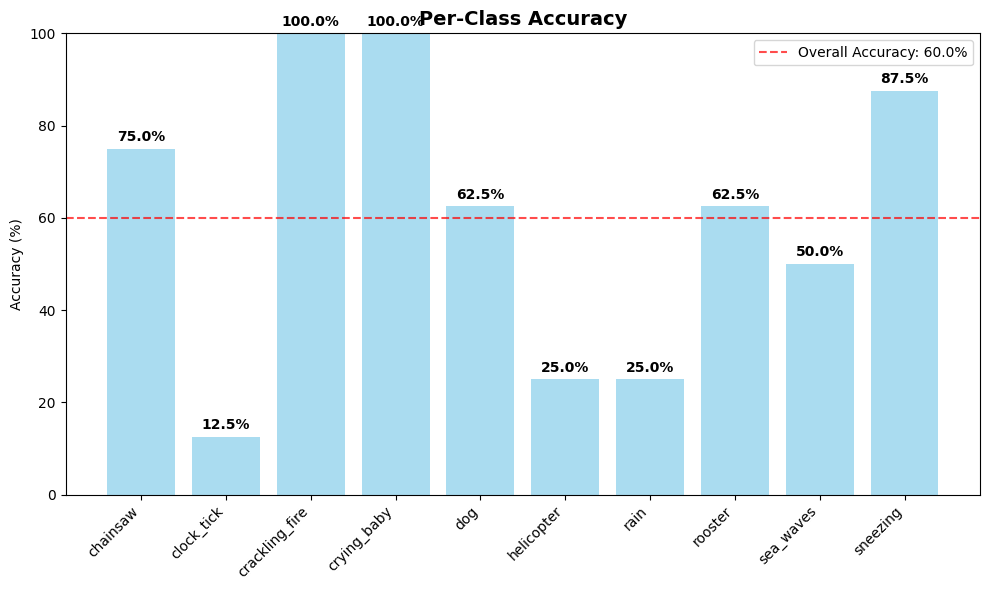

In [45]:
results_snn_delta = evaluate_model_comprehensive(delta_snn_classifier, delta_test_loader, ESCLabels.class_names, device)

##Delta Modulation: SCNN training

In [24]:
delta_c_snn_model = C_SNN(
    surr_grad=snn.surrogate.fast_sigmoid(),
    n_mels=N_MELS,
    num_classes=10,
    conv_channels1=8,
    dropout_rate=0.0,
    kernel_size=3,
    pool_kernel=2
).to(device)

summary(delta_c_snn_model, input_size=(BATCH_SIZE, 1, N_MELS))

Layer (type:depth-idx)                   Output Shape              Param #
C_SNN                                    [1, 32, 10]               --
├─Conv1d: 1-1                            [32, 8, 128]              24
├─Leaky: 1-2                             [32, 8, 128]              2
├─MaxPool1d: 1-3                         [32, 8, 64]               --
├─Dropout: 1-4                           [32, 512]                 --
├─Linear: 1-5                            [32, 10]                  5,120
├─Leaky: 1-6                             [32, 10]                  2
Total params: 5,148
Trainable params: 5,148
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.26
Input size (MB): 0.02
Forward/backward pass size (MB): 0.53
Params size (MB): 0.02
Estimated Total Size (MB): 0.57

In [25]:
optimizer = torch.optim.Adam(delta_c_snn_model.parameters(), lr=0.0001)

train_loss, train_acc, val_loss, val_acc = train_fn(
    model=delta_c_snn_model,
    train_loader=delta_train_loader,
    valid_loader=delta_val_loader,
    accuracy=SF.acc.accuracy_rate,
    loss_fn=snn.functional.ce_count_loss(),
    optimizer=optimizer,
    epochs=num_epochs,
    patience=patience,
    path="./",
    device=device,
    verbose=True,
)

Epochs:   1%|          | 1/100 [00:29<49:28, 29.98s/it]


Epoch 1/100 - 29s - loss: 2.3054 - acc: 0.1176 - val_loss: 2.2922 - val_acc: 0.0938



Epochs:   2%|▏         | 2/100 [01:00<49:52, 30.54s/it]


Epoch 2/100 - 30s - loss: 2.2801 - acc: 0.1349 - val_loss: 2.2844 - val_acc: 0.1146



Epochs:   3%|▎         | 3/100 [01:33<50:49, 31.44s/it]


Epoch 3/100 - 32s - loss: 2.1940 - acc: 0.1768 - val_loss: 2.2711 - val_acc: 0.1562



Epochs:   4%|▍         | 4/100 [02:04<49:49, 31.15s/it]


Epoch 4/100 - 30s - loss: 2.0950 - acc: 0.2155 - val_loss: 2.2604 - val_acc: 0.1667



Epochs:   5%|▌         | 5/100 [02:33<48:33, 30.67s/it]


Epoch 5/100 - 29s - loss: 1.9806 - acc: 0.2525 - val_loss: 2.0645 - val_acc: 0.2188



Epochs:   6%|▌         | 6/100 [03:03<47:27, 30.29s/it]


Epoch 6/100 - 29s - loss: 1.8849 - acc: 0.2837 - val_loss: 1.9521 - val_acc: 0.2917



Epochs:   7%|▋         | 7/100 [03:33<46:36, 30.07s/it]


Epoch 7/100 - 29s - loss: 1.7981 - acc: 0.3174 - val_loss: 1.9112 - val_acc: 0.3438



Epochs:   8%|▊         | 8/100 [04:02<45:56, 29.96s/it]


Epoch 8/100 - 29s - loss: 1.7070 - acc: 0.3396 - val_loss: 1.9166 - val_acc: 0.3021



Epochs:   9%|▉         | 9/100 [04:33<45:37, 30.09s/it]


Epoch 9/100 - 30s - loss: 1.5764 - acc: 0.4038 - val_loss: 1.8310 - val_acc: 0.3750



Epochs:  10%|█         | 10/100 [05:03<45:25, 30.28s/it]


Epoch 10/100 - 30s - loss: 1.4158 - acc: 0.4720 - val_loss: 1.6753 - val_acc: 0.3333



Epochs:  11%|█         | 11/100 [05:33<44:39, 30.11s/it]


Epoch 11/100 - 29s - loss: 1.2942 - acc: 0.4975 - val_loss: 1.5589 - val_acc: 0.4583



Epochs:  12%|█▏        | 12/100 [06:03<43:57, 29.97s/it]


Epoch 12/100 - 29s - loss: 1.2098 - acc: 0.5255 - val_loss: 1.6088 - val_acc: 0.4688



Epochs:  13%|█▎        | 13/100 [06:33<43:20, 29.89s/it]


Epoch 13/100 - 29s - loss: 1.1306 - acc: 0.5543 - val_loss: 1.4507 - val_acc: 0.5104



Epochs:  14%|█▍        | 14/100 [07:02<42:43, 29.81s/it]


Epoch 14/100 - 29s - loss: 1.0958 - acc: 0.5535 - val_loss: 1.3274 - val_acc: 0.4896



Epochs:  15%|█▌        | 15/100 [07:33<42:28, 29.99s/it]


Epoch 15/100 - 30s - loss: 1.0360 - acc: 0.5954 - val_loss: 1.2932 - val_acc: 0.4896



Epochs:  16%|█▌        | 16/100 [08:03<42:02, 30.03s/it]


Epoch 16/100 - 30s - loss: 0.9950 - acc: 0.6077 - val_loss: 1.2275 - val_acc: 0.4688



Epochs:  17%|█▋        | 17/100 [08:33<41:38, 30.11s/it]


Epoch 17/100 - 30s - loss: 0.9601 - acc: 0.6291 - val_loss: 1.1969 - val_acc: 0.5000



Epochs:  18%|█▊        | 18/100 [09:03<40:57, 29.97s/it]


Epoch 18/100 - 29s - loss: 0.9089 - acc: 0.6431 - val_loss: 1.2718 - val_acc: 0.4792



Epochs:  19%|█▉        | 19/100 [09:32<40:20, 29.89s/it]


Epoch 19/100 - 29s - loss: 0.8772 - acc: 0.6472 - val_loss: 1.2729 - val_acc: 0.5104



Epochs:  20%|██        | 20/100 [10:02<39:49, 29.87s/it]


Epoch 20/100 - 29s - loss: 0.8511 - acc: 0.6472 - val_loss: 1.2993 - val_acc: 0.5208



Epochs:  21%|██        | 21/100 [10:33<39:34, 30.06s/it]


Epoch 21/100 - 30s - loss: 0.8327 - acc: 0.6595 - val_loss: 1.1816 - val_acc: 0.5833



Epochs:  22%|██▏       | 22/100 [11:05<39:59, 30.76s/it]


Epoch 22/100 - 32s - loss: 0.7940 - acc: 0.6826 - val_loss: 1.1622 - val_acc: 0.5729



Epochs:  23%|██▎       | 23/100 [11:36<39:25, 30.71s/it]


Epoch 23/100 - 30s - loss: 0.7719 - acc: 0.6859 - val_loss: 1.1020 - val_acc: 0.5938



Epochs:  24%|██▍       | 24/100 [12:06<38:36, 30.48s/it]


Epoch 24/100 - 29s - loss: 0.7571 - acc: 0.6924 - val_loss: 1.1684 - val_acc: 0.5625



Epochs:  25%|██▌       | 25/100 [12:36<38:12, 30.57s/it]


Epoch 25/100 - 30s - loss: 0.7398 - acc: 0.7064 - val_loss: 1.1791 - val_acc: 0.5521



Epochs:  26%|██▌       | 26/100 [13:07<37:54, 30.74s/it]


Epoch 26/100 - 31s - loss: 0.7136 - acc: 0.7327 - val_loss: 1.0742 - val_acc: 0.5833



Epochs:  27%|██▋       | 27/100 [13:37<37:05, 30.48s/it]


Epoch 27/100 - 29s - loss: 0.7107 - acc: 0.7196 - val_loss: 1.1187 - val_acc: 0.5729



Epochs:  28%|██▊       | 28/100 [14:07<36:23, 30.33s/it]


Epoch 28/100 - 29s - loss: 0.6827 - acc: 0.7459 - val_loss: 1.0530 - val_acc: 0.6354



Epochs:  29%|██▉       | 29/100 [14:37<35:46, 30.23s/it]


Epoch 29/100 - 29s - loss: 0.6792 - acc: 0.7426 - val_loss: 1.0949 - val_acc: 0.5625



Epochs:  30%|███       | 30/100 [15:07<35:12, 30.18s/it]


Epoch 30/100 - 30s - loss: 0.6576 - acc: 0.7467 - val_loss: 1.0219 - val_acc: 0.6042



Epochs:  31%|███       | 31/100 [15:38<34:51, 30.31s/it]


Epoch 31/100 - 30s - loss: 0.6493 - acc: 0.7492 - val_loss: 1.0938 - val_acc: 0.5938



Epochs:  32%|███▏      | 32/100 [16:10<34:47, 30.69s/it]


Epoch 32/100 - 31s - loss: 0.6273 - acc: 0.7558 - val_loss: 1.1277 - val_acc: 0.6042



Epochs:  33%|███▎      | 33/100 [16:40<34:04, 30.51s/it]


Epoch 33/100 - 30s - loss: 0.6363 - acc: 0.7508 - val_loss: 1.0198 - val_acc: 0.6250



Epochs:  34%|███▍      | 34/100 [17:10<33:26, 30.40s/it]


Epoch 34/100 - 30s - loss: 0.5758 - acc: 0.7903 - val_loss: 1.0307 - val_acc: 0.6146



Epochs:  35%|███▌      | 35/100 [17:40<32:49, 30.30s/it]


Epoch 35/100 - 30s - loss: 0.5755 - acc: 0.7862 - val_loss: 0.9849 - val_acc: 0.6250



Epochs:  36%|███▌      | 36/100 [18:10<32:22, 30.35s/it]


Epoch 36/100 - 30s - loss: 0.5522 - acc: 0.8035 - val_loss: 1.0767 - val_acc: 0.6250



Epochs:  37%|███▋      | 37/100 [18:41<31:57, 30.44s/it]


Epoch 37/100 - 30s - loss: 0.5412 - acc: 0.7919 - val_loss: 1.0059 - val_acc: 0.6250



Epochs:  38%|███▊      | 38/100 [19:11<31:18, 30.29s/it]


Epoch 38/100 - 29s - loss: 0.5390 - acc: 0.7952 - val_loss: 1.0263 - val_acc: 0.6458



Epochs:  39%|███▉      | 39/100 [19:42<30:53, 30.39s/it]


Epoch 39/100 - 30s - loss: 0.5317 - acc: 0.7944 - val_loss: 1.0803 - val_acc: 0.6458



Epochs:  40%|████      | 40/100 [20:12<30:19, 30.32s/it]


Epoch 40/100 - 30s - loss: 0.5126 - acc: 0.8100 - val_loss: 0.9881 - val_acc: 0.6771



Epochs:  41%|████      | 41/100 [20:42<29:49, 30.32s/it]


Epoch 41/100 - 30s - loss: 0.5137 - acc: 0.7961 - val_loss: 0.9769 - val_acc: 0.6667



Epochs:  42%|████▏     | 42/100 [21:13<29:28, 30.48s/it]


Epoch 42/100 - 30s - loss: 0.4916 - acc: 0.8166 - val_loss: 0.9707 - val_acc: 0.6875



Epochs:  43%|████▎     | 43/100 [21:43<28:47, 30.31s/it]


Epoch 43/100 - 29s - loss: 0.4780 - acc: 0.8183 - val_loss: 0.9598 - val_acc: 0.6979



Epochs:  44%|████▍     | 44/100 [22:13<28:14, 30.25s/it]


Epoch 44/100 - 30s - loss: 0.4602 - acc: 0.8248 - val_loss: 0.8938 - val_acc: 0.6771



Epochs:  45%|████▌     | 45/100 [22:43<27:48, 30.33s/it]


Epoch 45/100 - 30s - loss: 0.4644 - acc: 0.8199 - val_loss: 0.9709 - val_acc: 0.6667



Epochs:  46%|████▌     | 46/100 [23:15<27:29, 30.55s/it]


Epoch 46/100 - 31s - loss: 0.4546 - acc: 0.8339 - val_loss: 0.9246 - val_acc: 0.6354



Epochs:  47%|████▋     | 47/100 [23:45<26:59, 30.55s/it]


Epoch 47/100 - 30s - loss: 0.4427 - acc: 0.8314 - val_loss: 0.8699 - val_acc: 0.6875



Epochs:  48%|████▊     | 48/100 [24:15<26:20, 30.39s/it]


Epoch 48/100 - 30s - loss: 0.4272 - acc: 0.8396 - val_loss: 0.8903 - val_acc: 0.7188



Epochs:  49%|████▉     | 49/100 [24:45<25:47, 30.33s/it]


Epoch 49/100 - 30s - loss: 0.4224 - acc: 0.8479 - val_loss: 0.8976 - val_acc: 0.6979



Epochs:  50%|█████     | 50/100 [25:15<25:12, 30.26s/it]


Epoch 50/100 - 30s - loss: 0.4231 - acc: 0.8446 - val_loss: 0.9186 - val_acc: 0.6667



Epochs:  51%|█████     | 51/100 [25:46<24:41, 30.24s/it]


Epoch 51/100 - 30s - loss: 0.4284 - acc: 0.8438 - val_loss: 0.8597 - val_acc: 0.6667



Epochs:  52%|█████▏    | 52/100 [26:17<24:26, 30.55s/it]


Epoch 52/100 - 31s - loss: 0.4236 - acc: 0.8462 - val_loss: 0.9219 - val_acc: 0.6667



Epochs:  53%|█████▎    | 53/100 [26:47<23:57, 30.59s/it]


Epoch 53/100 - 30s - loss: 0.4304 - acc: 0.8363 - val_loss: 0.9724 - val_acc: 0.6771



Epochs:  54%|█████▍    | 54/100 [27:18<23:19, 30.43s/it]


Epoch 54/100 - 30s - loss: 0.4292 - acc: 0.8396 - val_loss: 0.9804 - val_acc: 0.6458



Epochs:  55%|█████▌    | 55/100 [27:48<22:45, 30.35s/it]


Epoch 55/100 - 30s - loss: 0.4046 - acc: 0.8446 - val_loss: 0.9617 - val_acc: 0.6875



Epochs:  56%|█████▌    | 56/100 [28:18<22:15, 30.35s/it]


Epoch 56/100 - 30s - loss: 0.4087 - acc: 0.8470 - val_loss: 1.0398 - val_acc: 0.6979



Epochs:  57%|█████▋    | 57/100 [28:49<21:53, 30.56s/it]


Epoch 57/100 - 31s - loss: 0.3998 - acc: 0.8470 - val_loss: 0.9060 - val_acc: 0.6979



Epochs:  58%|█████▊    | 58/100 [29:19<21:17, 30.41s/it]


Epoch 58/100 - 30s - loss: 0.3915 - acc: 0.8413 - val_loss: 1.0034 - val_acc: 0.6771



Epochs:  59%|█████▉    | 59/100 [29:49<20:43, 30.33s/it]


Epoch 59/100 - 30s - loss: 0.4057 - acc: 0.8503 - val_loss: 0.8794 - val_acc: 0.6771



Epochs:  60%|██████    | 60/100 [30:20<20:20, 30.51s/it]


Epoch 60/100 - 30s - loss: 0.3903 - acc: 0.8553 - val_loss: 0.8952 - val_acc: 0.7083



Epochs:  61%|██████    | 61/100 [30:51<19:49, 30.51s/it]


Epoch 61/100 - 30s - loss: 0.3745 - acc: 0.8602 - val_loss: 0.9619 - val_acc: 0.7500



Epochs:  62%|██████▏   | 62/100 [31:22<19:26, 30.70s/it]


Epoch 62/100 - 31s - loss: 0.3725 - acc: 0.8651 - val_loss: 0.9027 - val_acc: 0.7292



Epochs:  63%|██████▎   | 63/100 [31:52<18:49, 30.51s/it]


Epoch 63/100 - 30s - loss: 0.3596 - acc: 0.8742 - val_loss: 1.0078 - val_acc: 0.6875



Epochs:  64%|██████▍   | 64/100 [32:22<18:15, 30.44s/it]


Epoch 64/100 - 30s - loss: 0.3664 - acc: 0.8627 - val_loss: 0.9631 - val_acc: 0.6875



Epochs:  65%|██████▌   | 65/100 [32:52<17:42, 30.36s/it]


Epoch 65/100 - 30s - loss: 0.3546 - acc: 0.8643 - val_loss: 0.9172 - val_acc: 0.6875



Epochs:  66%|██████▌   | 66/100 [33:23<17:11, 30.33s/it]


Epoch 66/100 - 30s - loss: 0.3597 - acc: 0.8701 - val_loss: 0.9875 - val_acc: 0.6562



Epochs:  67%|██████▋   | 67/100 [33:55<16:56, 30.81s/it]


Epoch 67/100 - 31s - loss: 0.3571 - acc: 0.8766 - val_loss: 0.9405 - val_acc: 0.6979



Epochs:  68%|██████▊   | 68/100 [34:25<16:19, 30.60s/it]


Epoch 68/100 - 30s - loss: 0.3460 - acc: 0.8717 - val_loss: 0.9602 - val_acc: 0.6771



Epochs:  69%|██████▉   | 69/100 [34:55<15:45, 30.49s/it]


Epoch 69/100 - 30s - loss: 0.3524 - acc: 0.8742 - val_loss: 0.9456 - val_acc: 0.7083



Epochs:  70%|███████   | 70/100 [35:25<15:13, 30.44s/it]


Epoch 70/100 - 30s - loss: 0.3321 - acc: 0.8750 - val_loss: 0.9057 - val_acc: 0.6979



Epochs:  71%|███████   | 71/100 [35:55<14:40, 30.36s/it]


Epoch 71/100 - 30s - loss: 0.3303 - acc: 0.8865 - val_loss: 0.9248 - val_acc: 0.7396



Epochs:  72%|███████▏  | 72/100 [36:27<14:17, 30.64s/it]


Epoch 72/100 - 31s - loss: 0.3351 - acc: 0.8783 - val_loss: 0.9656 - val_acc: 0.7396



Epochs:  73%|███████▎  | 73/100 [37:00<14:04, 31.28s/it]


Epoch 73/100 - 32s - loss: 0.3386 - acc: 0.8750 - val_loss: 0.9797 - val_acc: 0.7188



Epochs:  74%|███████▍  | 74/100 [37:30<13:27, 31.06s/it]


Epoch 74/100 - 30s - loss: 0.3636 - acc: 0.8742 - val_loss: 0.8830 - val_acc: 0.7083



Epochs:  75%|███████▌  | 75/100 [38:01<12:58, 31.15s/it]


Epoch 75/100 - 31s - loss: 0.3195 - acc: 0.8898 - val_loss: 0.9881 - val_acc: 0.6771



Epochs:  76%|███████▌  | 76/100 [38:33<12:27, 31.13s/it]


Epoch 76/100 - 31s - loss: 0.3197 - acc: 0.8939 - val_loss: 0.9389 - val_acc: 0.6979



Epochs:  77%|███████▋  | 77/100 [39:03<11:49, 30.86s/it]


Epoch 77/100 - 30s - loss: 0.3274 - acc: 0.8890 - val_loss: 0.9525 - val_acc: 0.7083



Epochs:  78%|███████▊  | 78/100 [39:33<11:15, 30.71s/it]


Epoch 78/100 - 30s - loss: 0.3132 - acc: 0.8840 - val_loss: 0.8791 - val_acc: 0.7292



Epochs:  79%|███████▉  | 79/100 [40:03<10:42, 30.60s/it]


Epoch 79/100 - 30s - loss: 0.3081 - acc: 0.8956 - val_loss: 0.9544 - val_acc: 0.6979



Epochs:  80%|████████  | 80/100 [40:34<10:11, 30.58s/it]


Epoch 80/100 - 30s - loss: 0.3230 - acc: 0.8906 - val_loss: 0.9777 - val_acc: 0.7083



Epochs:  80%|████████  | 80/100 [41:05<10:16, 30.82s/it]

Early stopping triggered


In [27]:
torch.save(delta_c_snn_model.state_dict(), '/content/drive/MyDrive/HumanData/best_models/delta_modulation/delta_scnn.pth')

##Delta Modulation: SCNN evaluation

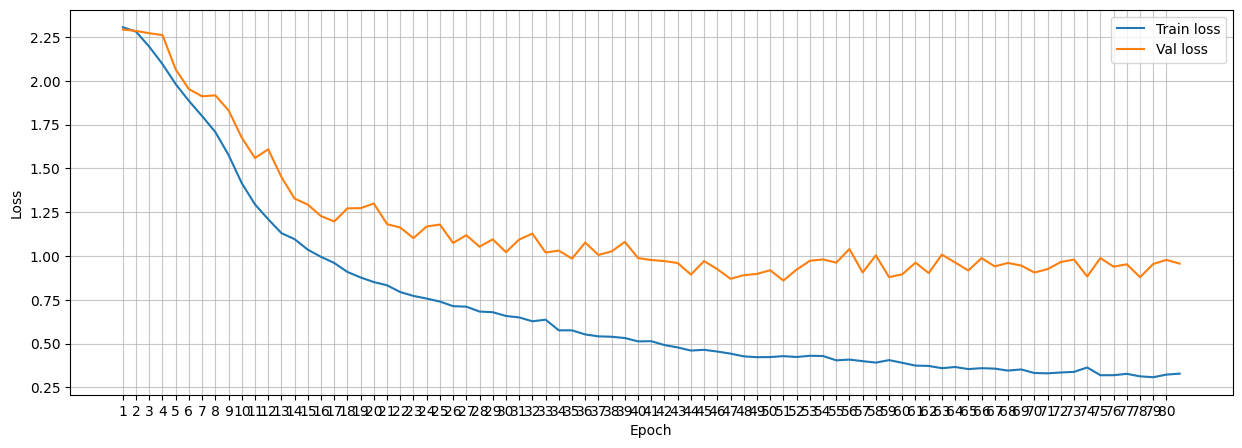

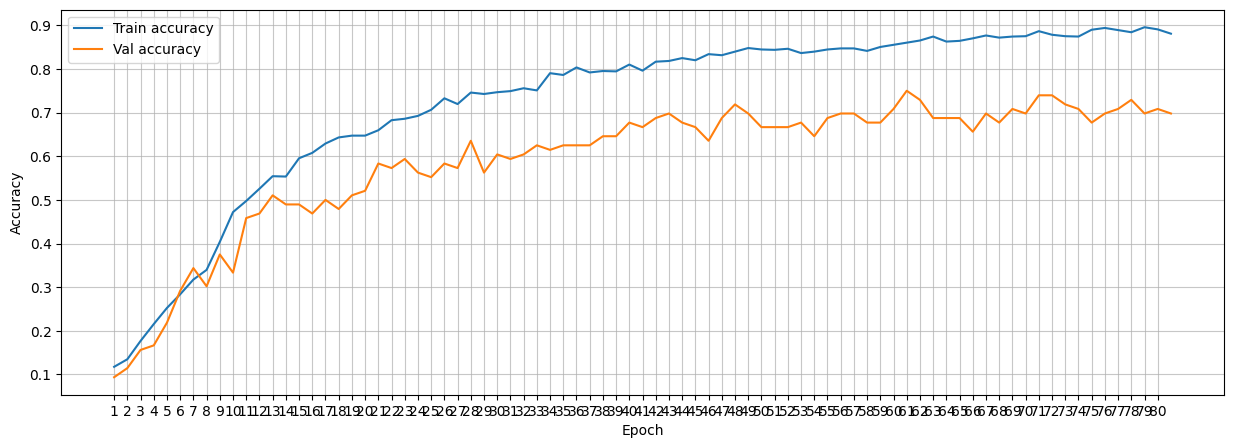

In [28]:
# Plot loss
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Val loss')
plt.xticks(np.arange(1, len(train_loss)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=.7)
plt.legend()

# Plot accuracy
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train accuracy')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Val accuracy')
plt.xticks(np.arange(1, len(train_acc)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=.7)
plt.legend()
plt.show()

COMPREHENSIVE EVALUATION RESULTS
Accuracy: 0.6500 (65.00%)

MACRO AVERAGES:
  F1-Score   : 0.6548
  Precision  : 0.6755
  Recall     : 0.6500

WEIGHTED AVERAGES:
  F1-Score   : 0.6548
  Precision  : 0.6755
  Recall     : 0.6500

PER-CLASS METRICS:
------------------------------------------------------------
Class           F1       Precision  Recall  
------------------------------------------------------------
chainsaw        0.7143   0.8333     0.6250  
clock_tick      0.6250   0.6250     0.6250  
crackling_fire  0.7059   0.6667     0.7500  
crying_baby     0.8750   0.8750     0.8750  
dog             0.7500   0.7500     0.7500  
helicopter      0.5333   0.5714     0.5000  
rain            0.5556   0.5000     0.6250  
rooster         0.7692   1.0000     0.6250  
sea_waves       0.3529   0.3333     0.3750  
sneezing        0.6667   0.6000     0.7500  

DETAILED CLASSIFICATION REPORT
                precision    recall  f1-score   support

      chainsaw     0.8333    0.6250    0.7143 

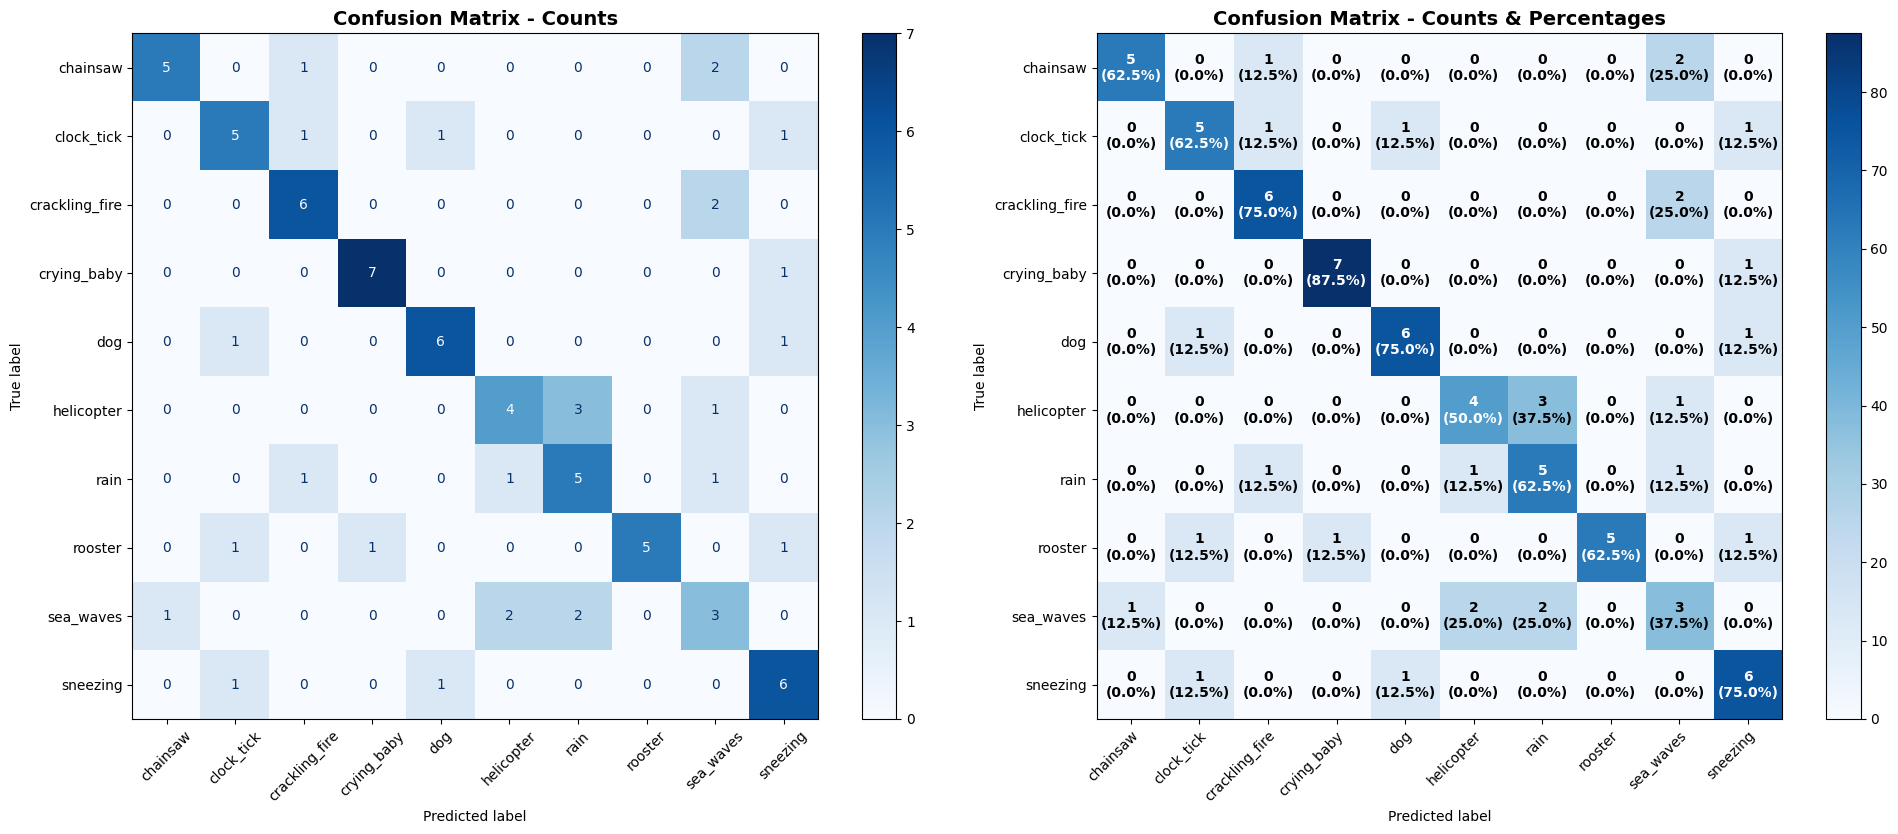


PER-CLASS ACCURACY BREAKDOWN
True Class      Correct  Total    Accuracy  
------------------------------------------------------------
chainsaw        5        8        62.50     %
clock_tick      5        8        62.50     %
crackling_fire  6        8        75.00     %
crying_baby     7        8        87.50     %
dog             6        8        75.00     %
helicopter      4        8        50.00     %
rain            5        8        62.50     %
rooster         5        8        62.50     %
sea_waves       3        8        37.50     %
sneezing        6        8        75.00     %


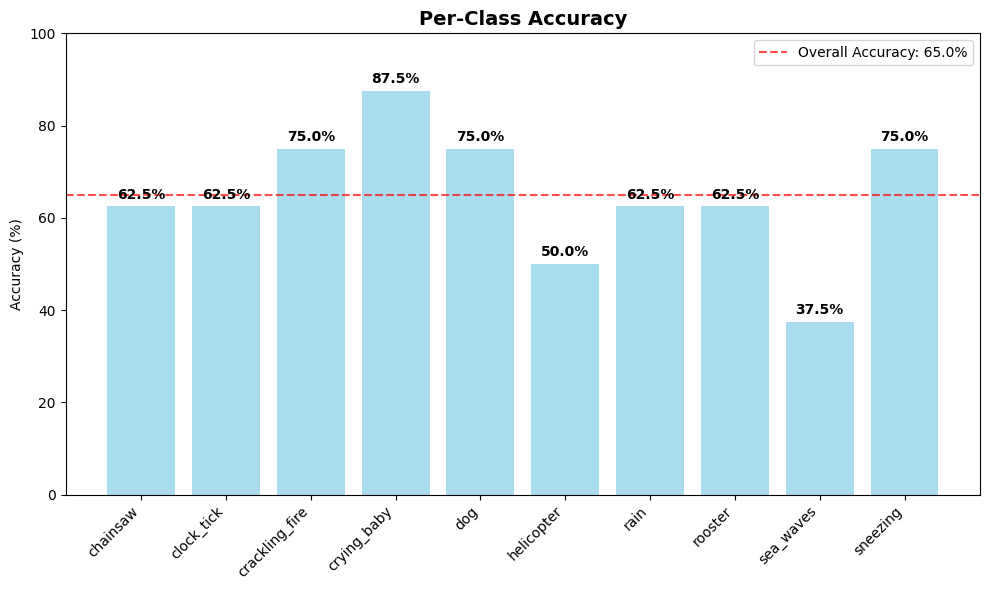

In [29]:
results_scnn_delta = evaluate_model_comprehensive(delta_c_snn_model, delta_test_loader, ESCLabels.class_names, device)

# Spike Encoding: Threshold Adaptive Encoding

In [ ]:
ALPHA = 0.999

In [ ]:
tae_train_dataset = ThresholdAdaptiveDataset(X_train_tensor, y_train_tensor, alpha=ALPHA)
tae_val_dataset = ThresholdAdaptiveDataset(X_val_tensor, y_val_tensor, alpha=ALPHA)
tae_test_dataset = ThresholdAdaptiveDataset(X_test_tensor, y_test_tensor, alpha=ALPHA)

In [ ]:
tae_train_loader = DataLoader(tae_train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                num_workers=2, pin_memory=torch.cuda.is_available())
tae_val_loader = DataLoader(tae_val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=2, pin_memory=torch.cuda.is_available())
tae_test_loader = DataLoader(tae_test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                               num_workers=2, pin_memory=torch.cuda.is_available())

In [ ]:
tae_X_batch, tae_y_batch = next(iter(tae_train_loader))
print("Threshold Adaptive encoding compleated!")

Threshold Adaptive encoding compleated!


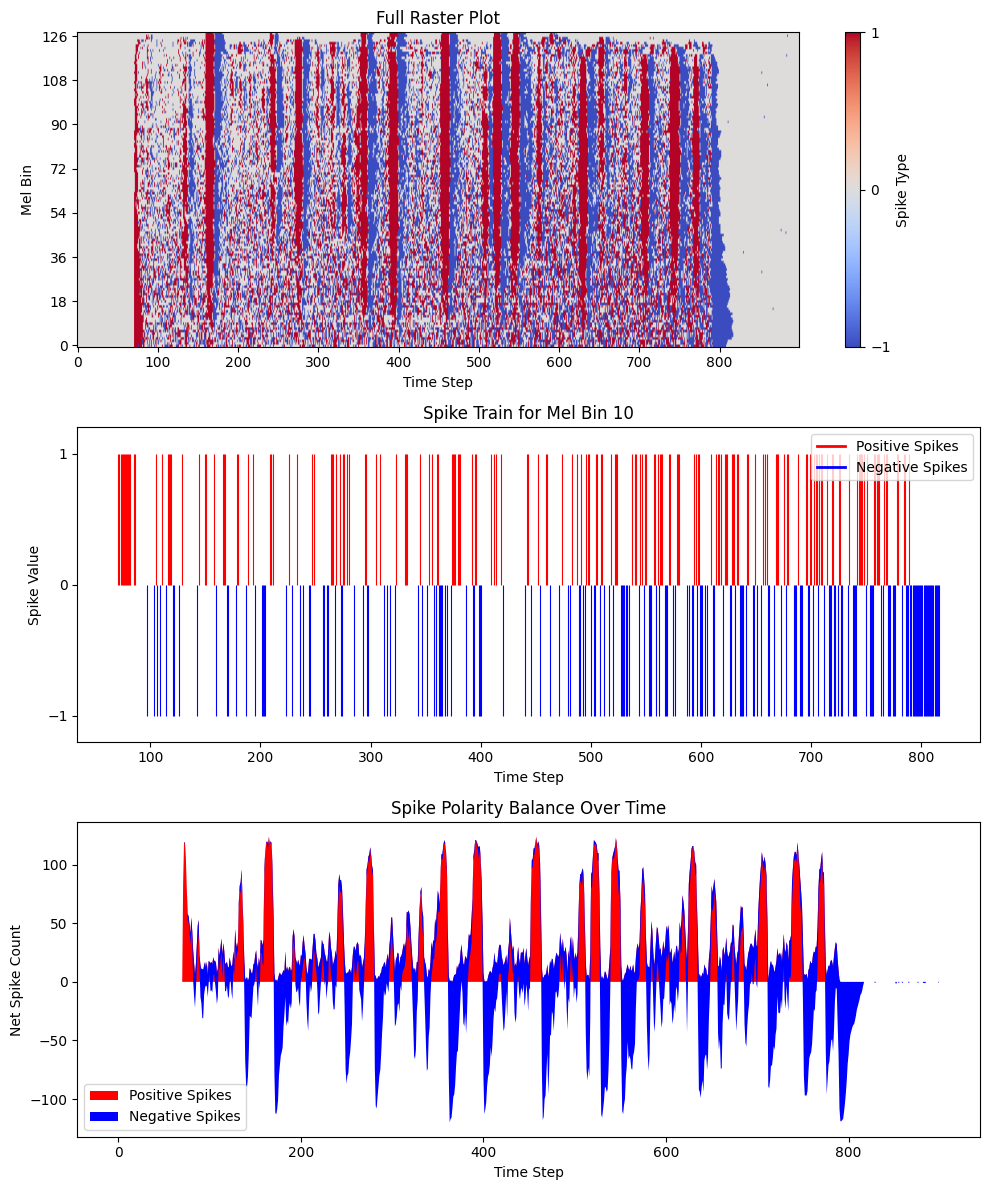

TAE Class: crackling_fire


In [ ]:
sample_idx = 10
visualize_spike_trains(tae_X_batch, sample_idx=sample_idx, mel_bin=10)
print(f"TAE Class: {ESCLabels.index_to_label[tae_y_batch[sample_idx].item()]}")

##TAE: SNN training

In [ ]:
tae_snn_classifier = SNNClassifier(
    n_mels=N_MELS,
    hidden_sizes=hidden_sizes,
    num_classes=num_classes,
    surr_grad=snn.surrogate.fast_sigmoid(),
    learn_thr=True,
    learn_beta=True
).to(device)

summary(tae_snn_classifier, input_size=(32, 1, N_MELS))

Layer (type:depth-idx)                   Output Shape              Param #
SNNClassifier                            [1, 32, 10]               --
├─Linear: 1-1                            [32, 128]                 16,512
├─Leaky: 1-2                             [32, 128]                 129
├─Linear: 1-3                            [32, 128]                 16,512
├─Leaky: 1-4                             [32, 128]                 129
├─Linear: 1-5                            [32, 128]                 16,512
├─Leaky: 1-6                             [32, 128]                 129
├─Linear: 1-7                            [32, 10]                  1,290
├─Leaky: 1-8                             [32, 10]                  11
Total params: 51,224
Trainable params: 51,224
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.63
Input size (MB): 0.02
Forward/backward pass size (MB): 0.20
Params size (MB): 0.20
Estimated Total Size (MB): 0.42

In [ ]:
optimizer = torch.optim.Adam(tae_snn_classifier.parameters(), lr=0.001)

train_loss, train_acc, val_loss, val_acc = train_fn(
    model=tae_snn_classifier,
    train_loader=tae_train_loader,
    valid_loader=tae_val_loader,
    accuracy=SF.acc.accuracy_rate,
    loss_fn=snn.functional.ce_count_loss(),
    optimizer=optimizer,
    epochs=num_epochs,
    patience=patience,
    path="./",
    device=device,
    verbose=True,
)

Epochs:   1%|          | 1/100 [03:55<6:28:05, 235.21s/it]


Epoch 1/100 - 235s - loss: 2.3026 - acc: 0.0987 - val_loss: 2.3026 - val_acc: 0.0938



Epochs:   2%|▏         | 2/100 [07:48<6:22:09, 233.97s/it]


Epoch 2/100 - 233s - loss: 2.3423 - acc: 0.1234 - val_loss: 2.2028 - val_acc: 0.1771



Epochs:   3%|▎         | 3/100 [11:41<6:17:31, 233.52s/it]


Epoch 3/100 - 232s - loss: 2.2812 - acc: 0.1826 - val_loss: 2.2526 - val_acc: 0.1562



Epochs:   4%|▍         | 4/100 [15:39<6:16:21, 235.22s/it]


Epoch 4/100 - 237s - loss: 2.2802 - acc: 0.2023 - val_loss: 2.3382 - val_acc: 0.2292



Epochs:   5%|▌         | 5/100 [19:34<6:12:17, 235.13s/it]


Epoch 5/100 - 234s - loss: 2.3107 - acc: 0.1727 - val_loss: 2.3002 - val_acc: 0.1875



Epochs:   6%|▌         | 6/100 [23:28<6:08:03, 234.93s/it]


Epoch 6/100 - 234s - loss: 2.3086 - acc: 0.1949 - val_loss: 2.1923 - val_acc: 0.2396



Epochs:   7%|▋         | 7/100 [27:31<6:08:13, 237.56s/it]


Epoch 7/100 - 242s - loss: 2.2937 - acc: 0.2410 - val_loss: 2.0540 - val_acc: 0.2604



Epochs:   8%|▊         | 8/100 [31:24<6:02:00, 236.10s/it]


Epoch 8/100 - 232s - loss: 2.2158 - acc: 0.2697 - val_loss: 2.2466 - val_acc: 0.2812



Epochs:   9%|▉         | 9/100 [35:20<5:57:49, 235.93s/it]


Epoch 9/100 - 235s - loss: 2.0734 - acc: 0.3651 - val_loss: 2.1673 - val_acc: 0.4167



Epochs:  10%|█         | 10/100 [39:14<5:53:13, 235.48s/it]


Epoch 10/100 - 234s - loss: 2.0774 - acc: 0.4145 - val_loss: 1.5557 - val_acc: 0.4792



Epochs:  11%|█         | 11/100 [43:08<5:48:30, 234.95s/it]


Epoch 11/100 - 233s - loss: 1.8200 - acc: 0.4309 - val_loss: 2.3575 - val_acc: 0.3958



Epochs:  12%|█▏        | 12/100 [47:02<5:44:00, 234.56s/it]


Epoch 12/100 - 233s - loss: 2.0118 - acc: 0.4507 - val_loss: 2.4026 - val_acc: 0.3958



Epochs:  13%|█▎        | 13/100 [50:57<5:40:33, 234.87s/it]


Epoch 13/100 - 235s - loss: 1.9678 - acc: 0.4342 - val_loss: 1.9873 - val_acc: 0.4167



Epochs:  14%|█▍        | 14/100 [54:52<5:36:37, 234.86s/it]


Epoch 14/100 - 234s - loss: 1.6058 - acc: 0.4942 - val_loss: 1.8579 - val_acc: 0.4375



Epochs:  15%|█▌        | 15/100 [58:47<5:32:37, 234.80s/it]


Epoch 15/100 - 234s - loss: 1.8717 - acc: 0.4770 - val_loss: 2.4399 - val_acc: 0.4479



Epochs:  16%|█▌        | 16/100 [1:02:41<5:28:33, 234.69s/it]


Epoch 16/100 - 234s - loss: 1.7392 - acc: 0.4959 - val_loss: 2.1214 - val_acc: 0.4479



Epochs:  17%|█▋        | 17/100 [1:06:35<5:24:31, 234.60s/it]


Epoch 17/100 - 234s - loss: 1.5478 - acc: 0.5337 - val_loss: 1.7078 - val_acc: 0.4896



Epochs:  18%|█▊        | 18/100 [1:10:29<5:20:08, 234.25s/it]


Epoch 18/100 - 233s - loss: 1.6181 - acc: 0.5510 - val_loss: 1.5893 - val_acc: 0.5521



Epochs:  19%|█▉        | 19/100 [1:14:21<5:15:27, 233.67s/it]


Epoch 19/100 - 232s - loss: 1.3616 - acc: 0.5765 - val_loss: 2.1769 - val_acc: 0.5417



Epochs:  20%|██        | 20/100 [1:18:15<5:11:34, 233.68s/it]


Epoch 20/100 - 233s - loss: 1.3890 - acc: 0.5609 - val_loss: 1.6492 - val_acc: 0.5208



Epochs:  21%|██        | 21/100 [1:22:10<5:08:05, 233.99s/it]


Epoch 21/100 - 234s - loss: 1.2816 - acc: 0.6094 - val_loss: 2.1070 - val_acc: 0.5104



Epochs:  22%|██▏       | 22/100 [1:26:03<5:04:02, 233.88s/it]


Epoch 22/100 - 233s - loss: 1.3806 - acc: 0.5962 - val_loss: 1.8324 - val_acc: 0.4688



Epochs:  23%|██▎       | 23/100 [1:29:57<5:00:10, 233.91s/it]


Epoch 23/100 - 233s - loss: 1.2296 - acc: 0.6365 - val_loss: 2.4327 - val_acc: 0.5833



Epochs:  24%|██▍       | 24/100 [1:33:52<4:56:33, 234.13s/it]


Epoch 24/100 - 234s - loss: 1.2619 - acc: 0.6497 - val_loss: 1.6181 - val_acc: 0.6354



Epochs:  25%|██▌       | 25/100 [1:37:46<4:52:36, 234.09s/it]


Epoch 25/100 - 234s - loss: 1.1129 - acc: 0.6562 - val_loss: 1.3539 - val_acc: 0.6458



Epochs:  26%|██▌       | 26/100 [1:41:41<4:49:16, 234.55s/it]


Epoch 26/100 - 235s - loss: 1.0921 - acc: 0.6686 - val_loss: 1.5662 - val_acc: 0.6458



Epochs:  27%|██▋       | 27/100 [1:45:36<4:45:27, 234.63s/it]


Epoch 27/100 - 234s - loss: 1.0887 - acc: 0.6842 - val_loss: 1.5178 - val_acc: 0.6667



Epochs:  28%|██▊       | 28/100 [1:49:31<4:41:43, 234.77s/it]


Epoch 28/100 - 235s - loss: 0.9774 - acc: 0.6990 - val_loss: 1.6467 - val_acc: 0.6562



Epochs:  29%|██▉       | 29/100 [1:53:27<4:38:09, 235.07s/it]


Epoch 29/100 - 235s - loss: 0.9543 - acc: 0.6998 - val_loss: 1.5335 - val_acc: 0.6562



Epochs:  30%|███       | 30/100 [1:57:23<4:34:40, 235.43s/it]


Epoch 30/100 - 236s - loss: 0.9252 - acc: 0.7204 - val_loss: 1.6643 - val_acc: 0.6979



Epochs:  31%|███       | 31/100 [2:01:18<4:30:29, 235.21s/it]


Epoch 31/100 - 234s - loss: 1.0773 - acc: 0.6941 - val_loss: 1.7384 - val_acc: 0.6875



Epochs:  32%|███▏      | 32/100 [2:05:12<4:26:05, 234.79s/it]


Epoch 32/100 - 233s - loss: 1.0389 - acc: 0.7031 - val_loss: 1.7230 - val_acc: 0.6562



Epochs:  33%|███▎      | 33/100 [2:09:05<4:21:42, 234.37s/it]


Epoch 33/100 - 233s - loss: 1.2030 - acc: 0.7007 - val_loss: 1.7793 - val_acc: 0.6458



Epochs:  34%|███▍      | 34/100 [2:13:02<4:18:32, 235.04s/it]


Epoch 34/100 - 236s - loss: 0.9803 - acc: 0.7229 - val_loss: 1.5365 - val_acc: 0.6979



Epochs:  35%|███▌      | 35/100 [2:16:58<4:14:52, 235.27s/it]


Epoch 35/100 - 235s - loss: 1.0296 - acc: 0.7237 - val_loss: 1.3276 - val_acc: 0.6562



Epochs:  36%|███▌      | 36/100 [2:20:53<4:10:49, 235.14s/it]


Epoch 36/100 - 234s - loss: 0.9394 - acc: 0.7508 - val_loss: 1.3803 - val_acc: 0.7500



Epochs:  37%|███▋      | 37/100 [2:24:45<4:06:06, 234.39s/it]


Epoch 37/100 - 232s - loss: 0.9347 - acc: 0.7656 - val_loss: 1.6133 - val_acc: 0.7396



Epochs:  38%|███▊      | 38/100 [2:28:40<4:02:27, 234.64s/it]


Epoch 38/100 - 235s - loss: 0.7780 - acc: 0.7796 - val_loss: 1.6357 - val_acc: 0.6667



Epochs:  39%|███▉      | 39/100 [2:32:36<3:58:42, 234.79s/it]


Epoch 39/100 - 235s - loss: 0.7945 - acc: 0.7706 - val_loss: 1.8408 - val_acc: 0.6562



Epochs:  40%|████      | 40/100 [2:36:30<3:54:46, 234.77s/it]


Epoch 40/100 - 234s - loss: 0.7732 - acc: 0.7771 - val_loss: 1.2336 - val_acc: 0.6875



Epochs:  41%|████      | 41/100 [2:40:24<3:50:31, 234.43s/it]


Epoch 41/100 - 233s - loss: 0.7449 - acc: 0.7862 - val_loss: 1.8555 - val_acc: 0.6562



Epochs:  42%|████▏     | 42/100 [2:44:16<3:45:53, 233.68s/it]


Epoch 42/100 - 231s - loss: 0.7824 - acc: 0.7697 - val_loss: 1.6821 - val_acc: 0.7292



Epochs:  43%|████▎     | 43/100 [2:48:13<3:42:54, 234.65s/it]


Epoch 43/100 - 236s - loss: 0.6934 - acc: 0.7985 - val_loss: 2.0285 - val_acc: 0.6146



Epochs:  44%|████▍     | 44/100 [2:52:09<3:39:22, 235.04s/it]


Epoch 44/100 - 235s - loss: 0.6951 - acc: 0.8018 - val_loss: 1.3903 - val_acc: 0.6979



Epochs:  45%|████▌     | 45/100 [2:56:04<3:35:26, 235.02s/it]


Epoch 45/100 - 234s - loss: 0.6358 - acc: 0.7903 - val_loss: 1.2049 - val_acc: 0.7396



Epochs:  46%|████▌     | 46/100 [3:00:00<3:31:45, 235.29s/it]


Epoch 46/100 - 235s - loss: 0.5938 - acc: 0.8289 - val_loss: 1.4330 - val_acc: 0.7396



Epochs:  47%|████▋     | 47/100 [3:03:55<3:27:58, 235.45s/it]


Epoch 47/100 - 235s - loss: 0.5862 - acc: 0.8174 - val_loss: 1.9603 - val_acc: 0.5938



Epochs:  48%|████▊     | 48/100 [3:07:50<3:23:53, 235.25s/it]


Epoch 48/100 - 234s - loss: 0.6727 - acc: 0.8067 - val_loss: 1.9923 - val_acc: 0.6667



Epochs:  49%|████▉     | 49/100 [3:11:46<3:20:09, 235.47s/it]


Epoch 49/100 - 235s - loss: 0.6095 - acc: 0.8314 - val_loss: 2.1120 - val_acc: 0.5938



Epochs:  50%|█████     | 50/100 [3:15:40<3:15:48, 234.96s/it]


Epoch 50/100 - 233s - loss: 0.6055 - acc: 0.8265 - val_loss: 1.9427 - val_acc: 0.7292



Epochs:  51%|█████     | 51/100 [3:19:35<3:11:49, 234.88s/it]


Epoch 51/100 - 234s - loss: 0.5918 - acc: 0.8355 - val_loss: 1.3756 - val_acc: 0.7812



Epochs:  52%|█████▏    | 52/100 [3:23:30<3:07:59, 234.99s/it]


Epoch 52/100 - 235s - loss: 0.5646 - acc: 0.8265 - val_loss: 1.6291 - val_acc: 0.7188



Epochs:  53%|█████▎    | 53/100 [3:27:25<3:04:04, 234.99s/it]


Epoch 53/100 - 234s - loss: 0.4663 - acc: 0.8487 - val_loss: 1.8153 - val_acc: 0.6771



Epochs:  54%|█████▍    | 54/100 [3:31:20<3:00:08, 234.98s/it]


Epoch 54/100 - 234s - loss: 0.4841 - acc: 0.8561 - val_loss: 1.5850 - val_acc: 0.6771



Epochs:  55%|█████▌    | 55/100 [3:35:15<2:56:13, 234.97s/it]


Epoch 55/100 - 234s - loss: 0.4312 - acc: 0.8569 - val_loss: 2.1412 - val_acc: 0.6250



Epochs:  56%|█████▌    | 56/100 [3:39:09<2:52:03, 234.61s/it]


Epoch 56/100 - 233s - loss: 0.4964 - acc: 0.8528 - val_loss: 1.8015 - val_acc: 0.6771



Epochs:  57%|█████▋    | 57/100 [3:43:03<2:48:11, 234.69s/it]


Epoch 57/100 - 234s - loss: 0.5549 - acc: 0.8479 - val_loss: 2.0757 - val_acc: 0.6667



Epochs:  58%|█████▊    | 58/100 [3:46:58<2:44:16, 234.67s/it]


Epoch 58/100 - 234s - loss: 0.7026 - acc: 0.8141 - val_loss: 2.2690 - val_acc: 0.6875



Epochs:  59%|█████▉    | 59/100 [3:50:52<2:40:17, 234.58s/it]


Epoch 59/100 - 234s - loss: 0.4665 - acc: 0.8873 - val_loss: 2.6812 - val_acc: 0.6042



Epochs:  60%|██████    | 60/100 [3:54:49<2:36:46, 235.17s/it]


Epoch 60/100 - 236s - loss: 0.6748 - acc: 0.8355 - val_loss: 2.4601 - val_acc: 0.6979



Epochs:  61%|██████    | 61/100 [3:58:41<2:32:13, 234.18s/it]


Epoch 61/100 - 231s - loss: 0.7878 - acc: 0.8191 - val_loss: 2.1532 - val_acc: 0.6875



Epochs:  62%|██████▏   | 62/100 [4:02:34<2:28:07, 233.87s/it]


Epoch 62/100 - 233s - loss: 0.7646 - acc: 0.8306 - val_loss: 2.1240 - val_acc: 0.7500



Epochs:  63%|██████▎   | 63/100 [4:06:28<2:24:12, 233.86s/it]


Epoch 63/100 - 233s - loss: 0.5451 - acc: 0.8692 - val_loss: 1.2141 - val_acc: 0.7812



Epochs:  64%|██████▍   | 64/100 [4:10:22<2:20:26, 234.08s/it]


Epoch 64/100 - 234s - loss: 0.4056 - acc: 0.8923 - val_loss: 1.7825 - val_acc: 0.7917



Epochs:  65%|██████▌   | 65/100 [4:14:16<2:16:26, 233.91s/it]


Epoch 65/100 - 233s - loss: 0.5022 - acc: 0.8610 - val_loss: 1.7188 - val_acc: 0.7188



Epochs:  66%|██████▌   | 66/100 [4:18:08<2:12:18, 233.49s/it]


Epoch 66/100 - 232s - loss: 0.6042 - acc: 0.8462 - val_loss: 1.7675 - val_acc: 0.7188



Epochs:  67%|██████▋   | 67/100 [4:22:02<2:08:26, 233.53s/it]


Epoch 67/100 - 233s - loss: 0.4989 - acc: 0.8512 - val_loss: 2.3053 - val_acc: 0.6354



Epochs:  68%|██████▊   | 68/100 [4:25:55<2:04:27, 233.37s/it]


Epoch 68/100 - 232s - loss: 0.4331 - acc: 0.8791 - val_loss: 2.0503 - val_acc: 0.7500



Epochs:  69%|██████▉   | 69/100 [4:29:49<2:00:41, 233.60s/it]


Epoch 69/100 - 234s - loss: 0.5614 - acc: 0.8520 - val_loss: 2.8444 - val_acc: 0.6562



Epochs:  70%|███████   | 70/100 [4:33:43<1:56:46, 233.56s/it]


Epoch 70/100 - 233s - loss: 0.5638 - acc: 0.8495 - val_loss: 1.6745 - val_acc: 0.7292



Epochs:  71%|███████   | 71/100 [4:37:35<1:52:39, 233.07s/it]


Epoch 71/100 - 231s - loss: 0.3751 - acc: 0.8964 - val_loss: 1.5340 - val_acc: 0.7917



Epochs:  72%|███████▏  | 72/100 [4:41:28<1:48:52, 233.31s/it]


Epoch 72/100 - 233s - loss: 0.2840 - acc: 0.9112 - val_loss: 1.7419 - val_acc: 0.7292



Epochs:  73%|███████▎  | 73/100 [4:45:22<1:45:01, 233.37s/it]


Epoch 73/100 - 233s - loss: 0.3437 - acc: 0.8988 - val_loss: 1.9972 - val_acc: 0.6979



Epochs:  74%|███████▍  | 74/100 [4:49:16<1:41:13, 233.59s/it]


Epoch 74/100 - 234s - loss: 0.3225 - acc: 0.8931 - val_loss: 1.6601 - val_acc: 0.7396



Epochs:  74%|███████▍  | 74/100 [4:53:11<1:43:00, 237.72s/it]

Early stopping triggered


In [ ]:
torch.save(tae_snn_classifier.state_dict(), '/content/drive/MyDrive/HumanData/best_models/tae/tae_snn.pth')

##TAE: SNN evaluation

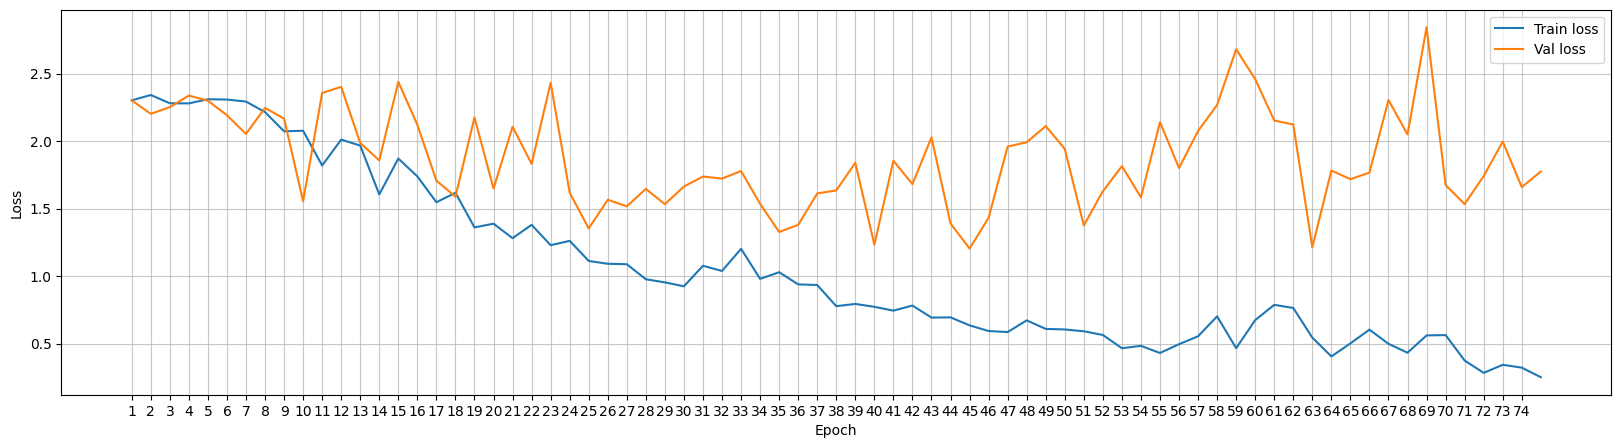

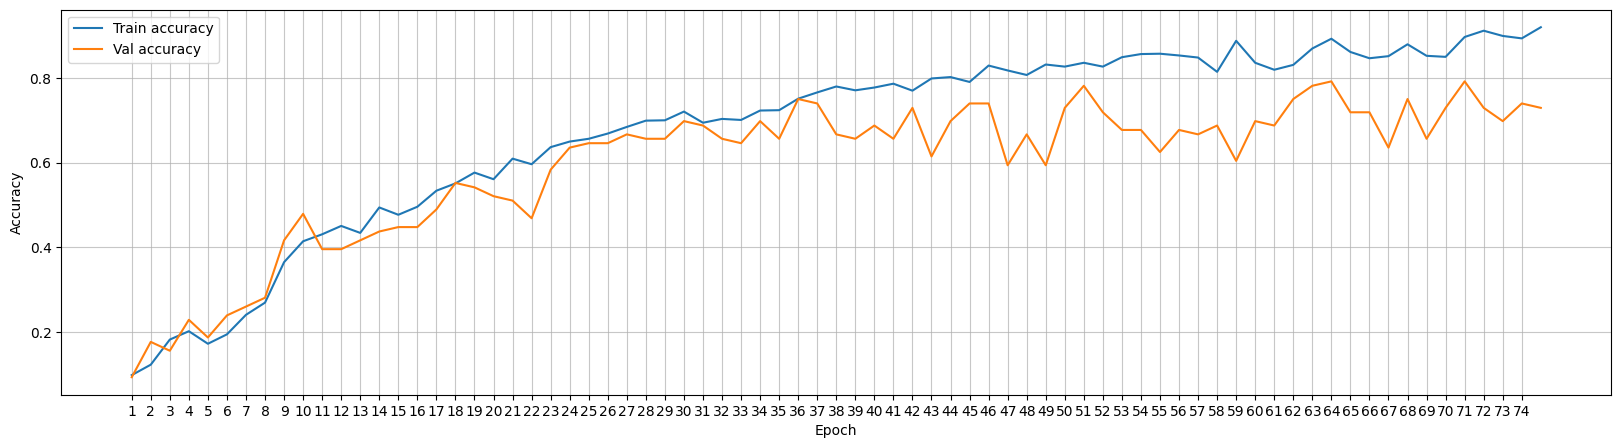

In [ ]:
# Plot loss
plt.figure(figsize=(20,5))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Val loss')
plt.xticks(np.arange(1, len(train_loss)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=.7)
plt.legend()

# Plot accuracy
plt.figure(figsize=(20,5))
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train accuracy')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Val accuracy')
plt.xticks(np.arange(1, len(train_acc)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=.7)
plt.legend()
plt.show()

COMPREHENSIVE EVALUATION RESULTS
Accuracy: 0.6625 (66.25%)

MACRO AVERAGES:
  F1-Score   : 0.6591
  Precision  : 0.7136
  Recall     : 0.6625

WEIGHTED AVERAGES:
  F1-Score   : 0.6591
  Precision  : 0.7136
  Recall     : 0.6625

PER-CLASS METRICS:
------------------------------------------------------------
Class           F1       Precision  Recall  
------------------------------------------------------------
chainsaw        0.8571   1.0000     0.7500  
clock_tick      0.6667   1.0000     0.5000  
crackling_fire  0.6087   0.4667     0.8750  
crying_baby     0.6250   0.6250     0.6250  
dog             0.6667   0.6000     0.7500  
helicopter      0.5714   0.6667     0.5000  
rain            0.7000   0.5833     0.8750  
rooster         0.5000   0.7500     0.3750  
sea_waves       0.8235   0.7778     0.8750  
sneezing        0.5714   0.6667     0.5000  

DETAILED CLASSIFICATION REPORT
                precision    recall  f1-score   support

      chainsaw     1.0000    0.7500    0.8571 

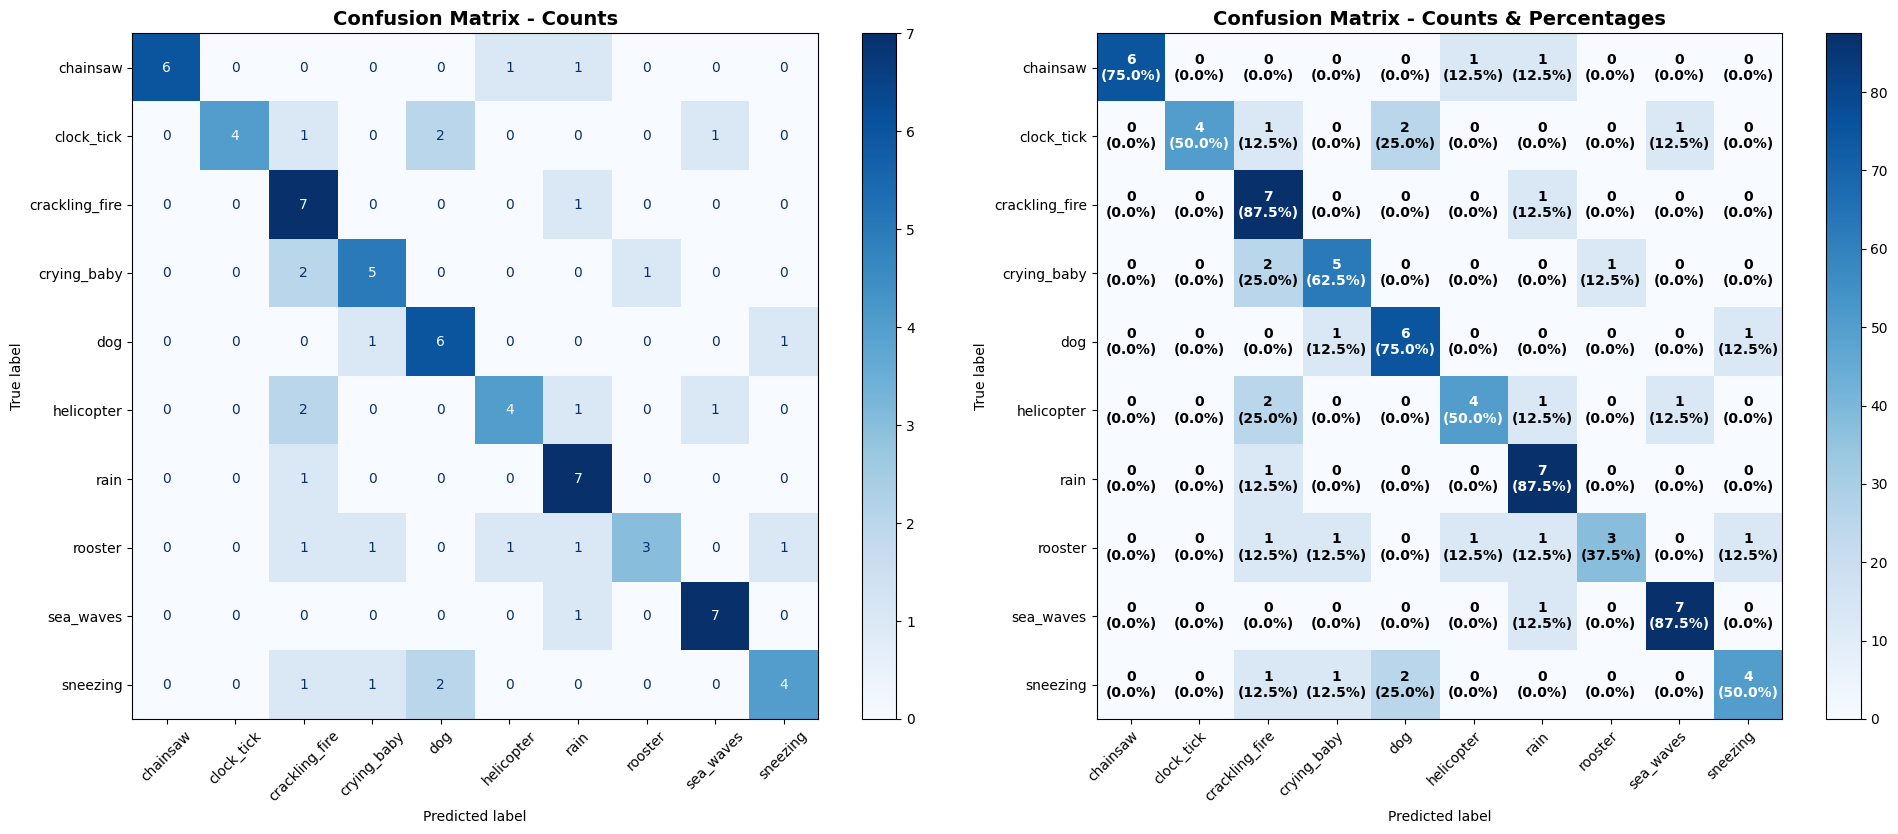


PER-CLASS ACCURACY BREAKDOWN
True Class      Correct  Total    Accuracy  
------------------------------------------------------------
chainsaw        6        8        75.00     %
clock_tick      4        8        50.00     %
crackling_fire  7        8        87.50     %
crying_baby     5        8        62.50     %
dog             6        8        75.00     %
helicopter      4        8        50.00     %
rain            7        8        87.50     %
rooster         3        8        37.50     %
sea_waves       7        8        87.50     %
sneezing        4        8        50.00     %


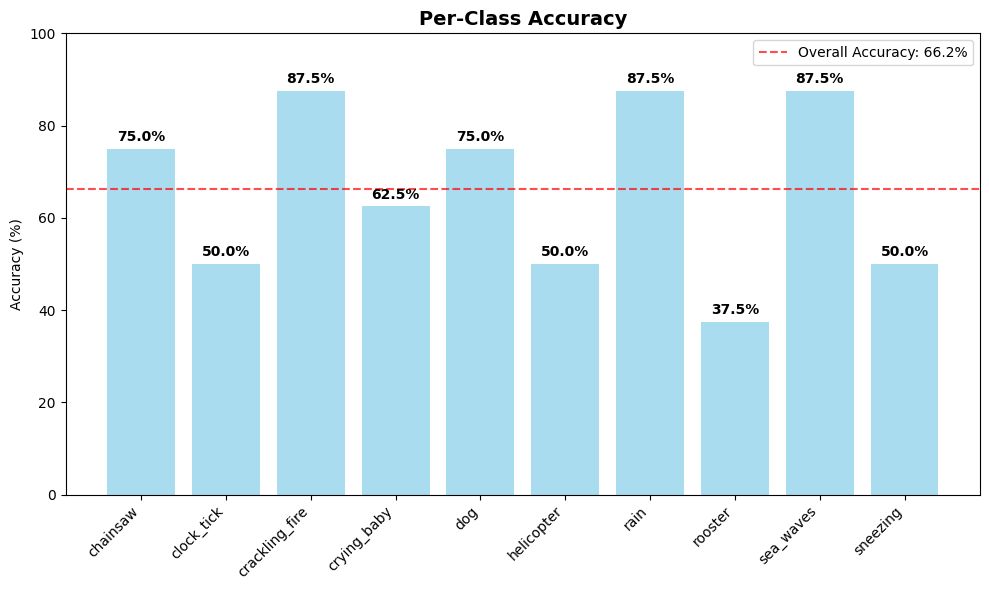

In [ ]:
results_snn_tae = evaluate_model_comprehensive(tae_snn_classifier, tae_test_loader, ESCLabels.class_names, device)

##TAE: SCNN training

In [ ]:
tae_c_snn_model = C_SNN(
    surr_grad=snn.surrogate.fast_sigmoid(),
    n_mels=N_MELS,
    num_classes=10,
    conv_channels1=8,
    dropout_rate=0.0,
    kernel_size=3,
    pool_kernel=2
).to(device)

summary(tae_c_snn_model, input_size=(BATCH_SIZE, 1, N_MELS))

Layer (type:depth-idx)                   Output Shape              Param #
C_SNN                                    [1, 32, 10]               --
├─Conv1d: 1-1                            [32, 8, 128]              24
├─Leaky: 1-2                             [32, 8, 128]              2
├─MaxPool1d: 1-3                         [32, 8, 64]               --
├─Dropout: 1-4                           [32, 512]                 --
├─Linear: 1-5                            [32, 10]                  5,120
├─Leaky: 1-6                             [32, 10]                  2
Total params: 5,148
Trainable params: 5,148
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.26
Input size (MB): 0.02
Forward/backward pass size (MB): 0.53
Params size (MB): 0.02
Estimated Total Size (MB): 0.57

In [ ]:
optimizer = torch.optim.Adam(tae_c_snn_model.parameters(), lr=0.0001)

train_loss, train_acc, val_loss, val_acc = train_fn(
    model=tae_c_snn_model,
    train_loader=tae_train_loader,
    valid_loader=tae_val_loader,
    accuracy=SF.acc.accuracy_rate,
    loss_fn=snn.functional.ce_count_loss(),
    optimizer=optimizer,
    epochs=num_epochs,
    patience=patience,
    path="./",
    device=device,
    verbose=True,
)

Epochs:   1%|          | 1/100 [03:27<5:42:31, 207.59s/it]


Epoch 1/100 - 207s - loss: 7.5909 - acc: 0.1077 - val_loss: 3.2583 - val_acc: 0.1250



Epochs:   2%|▏         | 2/100 [06:51<5:35:25, 205.36s/it]


Epoch 2/100 - 203s - loss: 2.6948 - acc: 0.2105 - val_loss: 2.4025 - val_acc: 0.2500



Epochs:   3%|▎         | 3/100 [10:19<5:33:45, 206.45s/it]


Epoch 3/100 - 207s - loss: 2.2247 - acc: 0.2434 - val_loss: 2.0862 - val_acc: 0.2917



Epochs:   4%|▍         | 4/100 [13:45<5:30:29, 206.55s/it]


Epoch 4/100 - 206s - loss: 2.1396 - acc: 0.2574 - val_loss: 2.1146 - val_acc: 0.2812



Epochs:   5%|▌         | 5/100 [17:12<5:27:15, 206.68s/it]


Epoch 5/100 - 206s - loss: 2.0772 - acc: 0.2722 - val_loss: 2.0391 - val_acc: 0.2812



Epochs:   6%|▌         | 6/100 [20:42<5:25:12, 207.58s/it]


Epoch 6/100 - 209s - loss: 2.0257 - acc: 0.2796 - val_loss: 2.0163 - val_acc: 0.2917



Epochs:   7%|▋         | 7/100 [24:10<5:22:13, 207.88s/it]


Epoch 7/100 - 208s - loss: 1.9808 - acc: 0.2919 - val_loss: 1.9862 - val_acc: 0.3125



Epochs:   8%|▊         | 8/100 [27:37<5:18:14, 207.55s/it]


Epoch 8/100 - 206s - loss: 1.9797 - acc: 0.2977 - val_loss: 1.9486 - val_acc: 0.3333



Epochs:   9%|▉         | 9/100 [31:03<5:14:11, 207.16s/it]


Epoch 9/100 - 206s - loss: 1.9392 - acc: 0.2993 - val_loss: 1.9065 - val_acc: 0.3125



Epochs:  10%|█         | 10/100 [34:33<5:11:55, 207.95s/it]


Epoch 10/100 - 209s - loss: 1.9246 - acc: 0.3273 - val_loss: 1.8572 - val_acc: 0.3333



Epochs:  11%|█         | 11/100 [37:58<5:07:08, 207.06s/it]


Epoch 11/100 - 205s - loss: 1.9012 - acc: 0.3240 - val_loss: 1.8737 - val_acc: 0.3229



Epochs:  12%|█▏        | 12/100 [41:19<5:00:48, 205.10s/it]


Epoch 12/100 - 200s - loss: 1.8451 - acc: 0.3454 - val_loss: 1.9129 - val_acc: 0.3542



Epochs:  13%|█▎        | 13/100 [44:39<4:55:08, 203.55s/it]


Epoch 13/100 - 199s - loss: 1.8506 - acc: 0.3470 - val_loss: 1.8780 - val_acc: 0.3333



Epochs:  14%|█▍        | 14/100 [48:04<4:52:22, 203.98s/it]


Epoch 14/100 - 204s - loss: 1.8221 - acc: 0.3462 - val_loss: 1.8526 - val_acc: 0.3854



Epochs:  15%|█▌        | 15/100 [51:28<4:49:05, 204.06s/it]


Epoch 15/100 - 204s - loss: 1.7761 - acc: 0.3758 - val_loss: 1.8139 - val_acc: 0.3958



Epochs:  16%|█▌        | 16/100 [54:51<4:45:28, 203.91s/it]


Epoch 16/100 - 203s - loss: 1.7082 - acc: 0.4112 - val_loss: 1.7931 - val_acc: 0.3958



Epochs:  17%|█▋        | 17/100 [58:10<4:40:04, 202.46s/it]


Epoch 17/100 - 199s - loss: 1.6741 - acc: 0.4276 - val_loss: 1.8049 - val_acc: 0.4062



Epochs:  18%|█▊        | 18/100 [1:01:35<4:37:28, 203.03s/it]


Epoch 18/100 - 204s - loss: 1.6258 - acc: 0.4334 - val_loss: 1.8381 - val_acc: 0.3854



Epochs:  19%|█▉        | 19/100 [1:04:58<4:34:21, 203.23s/it]


Epoch 19/100 - 203s - loss: 1.6614 - acc: 0.4301 - val_loss: 1.7027 - val_acc: 0.3854



Epochs:  20%|██        | 20/100 [1:08:23<4:31:38, 203.73s/it]


Epoch 20/100 - 204s - loss: 1.5763 - acc: 0.4400 - val_loss: 1.6532 - val_acc: 0.4167



Epochs:  21%|██        | 21/100 [1:11:42<4:26:03, 202.07s/it]


Epoch 21/100 - 198s - loss: 1.5797 - acc: 0.4457 - val_loss: 1.6532 - val_acc: 0.4062



Epochs:  22%|██▏       | 22/100 [1:15:02<4:21:51, 201.42s/it]


Epoch 22/100 - 199s - loss: 1.5801 - acc: 0.4720 - val_loss: 1.7220 - val_acc: 0.4167



Epochs:  23%|██▎       | 23/100 [1:18:23<4:18:26, 201.38s/it]


Epoch 23/100 - 201s - loss: 1.4607 - acc: 0.4959 - val_loss: 1.7143 - val_acc: 0.4062



Epochs:  24%|██▍       | 24/100 [1:21:51<4:17:42, 203.45s/it]


Epoch 24/100 - 208s - loss: 1.4851 - acc: 0.4926 - val_loss: 1.7238 - val_acc: 0.4479



Epochs:  25%|██▌       | 25/100 [1:25:15<4:14:28, 203.59s/it]


Epoch 25/100 - 203s - loss: 1.4712 - acc: 0.4918 - val_loss: 1.7032 - val_acc: 0.4271



Epochs:  26%|██▌       | 26/100 [1:28:40<4:11:47, 204.16s/it]


Epoch 26/100 - 205s - loss: 1.4525 - acc: 0.5016 - val_loss: 1.6273 - val_acc: 0.4583



Epochs:  27%|██▋       | 27/100 [1:32:05<4:08:22, 204.14s/it]


Epoch 27/100 - 204s - loss: 1.4286 - acc: 0.5214 - val_loss: 1.6670 - val_acc: 0.5104



Epochs:  28%|██▊       | 28/100 [1:35:26<4:04:08, 203.45s/it]


Epoch 28/100 - 201s - loss: 1.3925 - acc: 0.5312 - val_loss: 1.5607 - val_acc: 0.5104



Epochs:  29%|██▉       | 29/100 [1:38:50<4:00:42, 203.42s/it]


Epoch 29/100 - 203s - loss: 1.3645 - acc: 0.5477 - val_loss: 1.7397 - val_acc: 0.5417



Epochs:  30%|███       | 30/100 [1:42:13<3:57:11, 203.30s/it]


Epoch 30/100 - 203s - loss: 1.3545 - acc: 0.5526 - val_loss: 1.7924 - val_acc: 0.4375



Epochs:  31%|███       | 31/100 [1:45:37<3:54:05, 203.55s/it]


Epoch 31/100 - 204s - loss: 1.2799 - acc: 0.5551 - val_loss: 1.7134 - val_acc: 0.4792



Epochs:  32%|███▏      | 32/100 [1:49:01<3:50:49, 203.67s/it]


Epoch 32/100 - 203s - loss: 1.2651 - acc: 0.5863 - val_loss: 1.7412 - val_acc: 0.4271



Epochs:  33%|███▎      | 33/100 [1:52:22<3:46:28, 202.82s/it]


Epoch 33/100 - 200s - loss: 1.2154 - acc: 0.5913 - val_loss: 1.5803 - val_acc: 0.4896



Epochs:  34%|███▍      | 34/100 [1:55:44<3:42:47, 202.54s/it]


Epoch 34/100 - 201s - loss: 1.1985 - acc: 0.5921 - val_loss: 1.6233 - val_acc: 0.5312



Epochs:  35%|███▌      | 35/100 [1:59:03<3:38:32, 201.73s/it]


Epoch 35/100 - 199s - loss: 1.2383 - acc: 0.5732 - val_loss: 1.5653 - val_acc: 0.5521



Epochs:  36%|███▌      | 36/100 [2:02:30<3:36:39, 203.12s/it]


Epoch 36/100 - 206s - loss: 1.2199 - acc: 0.5724 - val_loss: 1.5894 - val_acc: 0.5417



Epochs:  37%|███▋      | 37/100 [2:05:54<3:33:41, 203.52s/it]


Epoch 37/100 - 204s - loss: 1.1871 - acc: 0.5888 - val_loss: 1.5202 - val_acc: 0.5312



Epochs:  38%|███▊      | 38/100 [2:09:19<3:30:35, 203.79s/it]


Epoch 38/100 - 204s - loss: 1.1569 - acc: 0.6003 - val_loss: 1.4182 - val_acc: 0.5625



Epochs:  39%|███▉      | 39/100 [2:12:43<3:27:22, 203.97s/it]


Epoch 39/100 - 204s - loss: 1.1692 - acc: 0.6003 - val_loss: 1.5060 - val_acc: 0.5729



Epochs:  40%|████      | 40/100 [2:16:07<3:24:00, 204.01s/it]


Epoch 40/100 - 204s - loss: 1.0925 - acc: 0.6143 - val_loss: 1.5278 - val_acc: 0.5833



Epochs:  41%|████      | 41/100 [2:19:29<3:20:02, 203.43s/it]


Epoch 41/100 - 202s - loss: 1.0716 - acc: 0.6299 - val_loss: 1.4406 - val_acc: 0.6042



Epochs:  42%|████▏     | 42/100 [2:22:54<3:17:03, 203.86s/it]


Epoch 42/100 - 204s - loss: 1.0729 - acc: 0.6414 - val_loss: 1.4316 - val_acc: 0.5938



Epochs:  43%|████▎     | 43/100 [2:26:23<3:15:12, 205.48s/it]


Epoch 43/100 - 209s - loss: 1.0186 - acc: 0.6612 - val_loss: 1.3459 - val_acc: 0.5938



Epochs:  44%|████▍     | 44/100 [2:29:48<3:11:25, 205.10s/it]


Epoch 44/100 - 204s - loss: 1.0002 - acc: 0.6669 - val_loss: 1.3491 - val_acc: 0.6146



Epochs:  45%|████▌     | 45/100 [2:33:11<3:07:32, 204.58s/it]


Epoch 45/100 - 203s - loss: 1.0213 - acc: 0.6686 - val_loss: 1.2289 - val_acc: 0.6146



Epochs:  46%|████▌     | 46/100 [2:36:37<3:04:33, 205.06s/it]


Epoch 46/100 - 206s - loss: 0.9254 - acc: 0.6941 - val_loss: 1.3507 - val_acc: 0.6250



Epochs:  47%|████▋     | 47/100 [2:40:04<3:01:43, 205.73s/it]


Epoch 47/100 - 207s - loss: 0.9605 - acc: 0.6817 - val_loss: 1.3050 - val_acc: 0.6667



Epochs:  48%|████▊     | 48/100 [2:43:28<2:57:44, 205.09s/it]


Epoch 48/100 - 203s - loss: 0.9060 - acc: 0.6949 - val_loss: 1.4325 - val_acc: 0.6771



Epochs:  49%|████▉     | 49/100 [2:46:54<2:54:27, 205.25s/it]


Epoch 49/100 - 205s - loss: 0.9987 - acc: 0.6900 - val_loss: 1.4231 - val_acc: 0.6667



Epochs:  50%|█████     | 50/100 [2:50:20<2:51:24, 205.68s/it]


Epoch 50/100 - 206s - loss: 0.9080 - acc: 0.6965 - val_loss: 1.3072 - val_acc: 0.6771



Epochs:  51%|█████     | 51/100 [2:53:48<2:48:24, 206.21s/it]


Epoch 51/100 - 207s - loss: 0.9280 - acc: 0.6998 - val_loss: 1.1088 - val_acc: 0.7083



Epochs:  52%|█████▏    | 52/100 [2:57:13<2:44:44, 205.92s/it]


Epoch 52/100 - 205s - loss: 0.8347 - acc: 0.7311 - val_loss: 1.1566 - val_acc: 0.6562



Epochs:  53%|█████▎    | 53/100 [3:00:35<2:40:23, 204.75s/it]


Epoch 53/100 - 201s - loss: 0.8202 - acc: 0.7196 - val_loss: 1.2193 - val_acc: 0.6875



Epochs:  54%|█████▍    | 54/100 [3:03:58<2:36:35, 204.25s/it]


Epoch 54/100 - 203s - loss: 0.8869 - acc: 0.7155 - val_loss: 1.3402 - val_acc: 0.7083



Epochs:  55%|█████▌    | 55/100 [3:07:24<2:33:36, 204.82s/it]


Epoch 55/100 - 206s - loss: 0.7953 - acc: 0.7237 - val_loss: 1.0016 - val_acc: 0.7188



Epochs:  56%|█████▌    | 56/100 [3:10:48<2:29:51, 204.35s/it]


Epoch 56/100 - 203s - loss: 0.7461 - acc: 0.7426 - val_loss: 1.2065 - val_acc: 0.6771



Epochs:  57%|█████▋    | 57/100 [3:14:08<2:25:43, 203.33s/it]


Epoch 57/100 - 200s - loss: 0.7624 - acc: 0.7385 - val_loss: 1.1161 - val_acc: 0.6979



Epochs:  58%|█████▊    | 58/100 [3:17:34<2:22:41, 203.85s/it]


Epoch 58/100 - 205s - loss: 0.7248 - acc: 0.7442 - val_loss: 0.8919 - val_acc: 0.7083



Epochs:  59%|█████▉    | 59/100 [3:20:59<2:19:36, 204.31s/it]


Epoch 59/100 - 205s - loss: 0.6739 - acc: 0.7714 - val_loss: 1.0808 - val_acc: 0.7188



Epochs:  60%|██████    | 60/100 [3:24:22<2:15:55, 203.89s/it]


Epoch 60/100 - 202s - loss: 0.6547 - acc: 0.7804 - val_loss: 0.9360 - val_acc: 0.7604



Epochs:  61%|██████    | 61/100 [3:27:45<2:12:25, 203.73s/it]


Epoch 61/100 - 203s - loss: 0.6190 - acc: 0.7870 - val_loss: 1.1139 - val_acc: 0.7083



Epochs:  62%|██████▏   | 62/100 [3:31:09<2:09:01, 203.72s/it]


Epoch 62/100 - 203s - loss: 0.6322 - acc: 0.7903 - val_loss: 1.0149 - val_acc: 0.7292



Epochs:  63%|██████▎   | 63/100 [3:34:33<2:05:45, 203.92s/it]


Epoch 63/100 - 204s - loss: 0.6621 - acc: 0.7788 - val_loss: 1.0065 - val_acc: 0.6875



Epochs:  64%|██████▍   | 64/100 [3:37:55<2:01:54, 203.19s/it]


Epoch 64/100 - 201s - loss: 0.6310 - acc: 0.7812 - val_loss: 0.9810 - val_acc: 0.7396



Epochs:  65%|██████▌   | 65/100 [3:41:20<1:58:53, 203.82s/it]


Epoch 65/100 - 205s - loss: 0.6236 - acc: 0.7788 - val_loss: 1.0254 - val_acc: 0.7188



Epochs:  66%|██████▌   | 66/100 [3:44:43<1:55:17, 203.45s/it]


Epoch 66/100 - 202s - loss: 0.6221 - acc: 0.7903 - val_loss: 0.9682 - val_acc: 0.6771



Epochs:  67%|██████▋   | 67/100 [3:48:06<1:51:51, 203.38s/it]


Epoch 67/100 - 203s - loss: 0.6059 - acc: 0.7870 - val_loss: 0.9710 - val_acc: 0.6979



Epochs:  68%|██████▊   | 68/100 [3:51:29<1:48:24, 203.26s/it]


Epoch 68/100 - 202s - loss: 0.5673 - acc: 0.8076 - val_loss: 0.9535 - val_acc: 0.7188



Epochs:  69%|██████▉   | 69/100 [3:54:51<1:44:55, 203.08s/it]


Epoch 69/100 - 202s - loss: 0.5861 - acc: 0.7944 - val_loss: 0.9518 - val_acc: 0.6979



Epochs:  70%|███████   | 70/100 [3:58:14<1:41:30, 203.02s/it]


Epoch 70/100 - 202s - loss: 0.5518 - acc: 0.8150 - val_loss: 0.9660 - val_acc: 0.7083



Epochs:  71%|███████   | 71/100 [4:01:38<1:38:13, 203.21s/it]


Epoch 71/100 - 203s - loss: 0.5381 - acc: 0.8191 - val_loss: 1.0768 - val_acc: 0.6875



Epochs:  72%|███████▏  | 72/100 [4:05:01<1:34:51, 203.28s/it]


Epoch 72/100 - 203s - loss: 0.5509 - acc: 0.8084 - val_loss: 0.9889 - val_acc: 0.6771



Epochs:  73%|███████▎  | 73/100 [4:08:23<1:31:15, 202.81s/it]


Epoch 73/100 - 201s - loss: 0.5270 - acc: 0.8224 - val_loss: 1.0000 - val_acc: 0.7083



Epochs:  74%|███████▍  | 74/100 [4:11:52<1:28:41, 204.69s/it]


Epoch 74/100 - 209s - loss: 0.5295 - acc: 0.8191 - val_loss: 1.0078 - val_acc: 0.6979



Epochs:  75%|███████▌  | 75/100 [4:15:16<1:25:10, 204.41s/it]


Epoch 75/100 - 203s - loss: 0.5255 - acc: 0.8084 - val_loss: 0.9150 - val_acc: 0.6875



Epochs:  76%|███████▌  | 76/100 [4:18:40<1:21:46, 204.43s/it]


Epoch 76/100 - 204s - loss: 0.5281 - acc: 0.8141 - val_loss: 0.9661 - val_acc: 0.7500



Epochs:  77%|███████▋  | 77/100 [4:22:04<1:18:17, 204.23s/it]


Epoch 77/100 - 203s - loss: 0.5236 - acc: 0.8141 - val_loss: 0.9390 - val_acc: 0.7292



Epochs:  78%|███████▊  | 78/100 [4:25:29<1:14:58, 204.48s/it]


Epoch 78/100 - 205s - loss: 0.5125 - acc: 0.8199 - val_loss: 1.0828 - val_acc: 0.6875



Epochs:  79%|███████▉  | 79/100 [4:28:54<1:11:36, 204.57s/it]


Epoch 79/100 - 204s - loss: 0.5217 - acc: 0.8125 - val_loss: 1.0025 - val_acc: 0.7292



Epochs:  80%|████████  | 80/100 [4:32:18<1:08:06, 204.31s/it]


Epoch 80/100 - 203s - loss: 0.4997 - acc: 0.8248 - val_loss: 0.9369 - val_acc: 0.6979



Epochs:  81%|████████  | 81/100 [4:35:43<1:04:49, 204.70s/it]


Epoch 81/100 - 205s - loss: 0.5024 - acc: 0.8191 - val_loss: 0.8888 - val_acc: 0.6771



Epochs:  82%|████████▏ | 82/100 [4:39:07<1:01:18, 204.35s/it]


Epoch 82/100 - 203s - loss: 0.4517 - acc: 0.8405 - val_loss: 1.0433 - val_acc: 0.6979



Epochs:  83%|████████▎ | 83/100 [4:42:32<57:56, 204.53s/it]  


Epoch 83/100 - 204s - loss: 0.4637 - acc: 0.8363 - val_loss: 0.9908 - val_acc: 0.7083



Epochs:  84%|████████▍ | 84/100 [4:45:56<54:32, 204.56s/it]


Epoch 84/100 - 204s - loss: 0.4366 - acc: 0.8396 - val_loss: 1.1749 - val_acc: 0.7083



Epochs:  85%|████████▌ | 85/100 [4:49:21<51:06, 204.43s/it]


Epoch 85/100 - 204s - loss: 0.4126 - acc: 0.8503 - val_loss: 1.0020 - val_acc: 0.6771



Epochs:  86%|████████▌ | 86/100 [4:52:47<47:51, 205.07s/it]


Epoch 86/100 - 206s - loss: 0.4338 - acc: 0.8405 - val_loss: 1.3775 - val_acc: 0.7396



Epochs:  87%|████████▋ | 87/100 [4:56:10<44:16, 204.36s/it]


Epoch 87/100 - 202s - loss: 0.4269 - acc: 0.8503 - val_loss: 0.9999 - val_acc: 0.6562



Epochs:  88%|████████▊ | 88/100 [4:59:32<40:45, 203.79s/it]


Epoch 88/100 - 202s - loss: 0.4341 - acc: 0.8561 - val_loss: 0.9899 - val_acc: 0.7292



Epochs:  89%|████████▉ | 89/100 [5:02:54<37:16, 203.28s/it]


Epoch 89/100 - 202s - loss: 0.4254 - acc: 0.8544 - val_loss: 1.1147 - val_acc: 0.7083



Epochs:  90%|█████████ | 90/100 [5:06:16<33:48, 202.81s/it]


Epoch 90/100 - 201s - loss: 0.4130 - acc: 0.8536 - val_loss: 1.0951 - val_acc: 0.7083



Epochs:  91%|█████████ | 91/100 [5:09:40<30:27, 203.11s/it]


Epoch 91/100 - 203s - loss: 0.4353 - acc: 0.8561 - val_loss: 1.0958 - val_acc: 0.7292



Epochs:  92%|█████████▏| 92/100 [5:13:07<27:15, 204.40s/it]


Epoch 92/100 - 207s - loss: 0.3942 - acc: 0.8627 - val_loss: 1.0933 - val_acc: 0.7292



Epochs:  93%|█████████▎| 93/100 [5:16:31<23:49, 204.24s/it]


Epoch 93/100 - 203s - loss: 0.4406 - acc: 0.8495 - val_loss: 0.9995 - val_acc: 0.6979



Epochs:  94%|█████████▍| 94/100 [5:19:57<20:27, 204.62s/it]


Epoch 94/100 - 205s - loss: 0.4219 - acc: 0.8520 - val_loss: 1.1797 - val_acc: 0.7083



Epochs:  95%|█████████▌| 95/100 [5:23:20<17:01, 204.23s/it]


Epoch 95/100 - 203s - loss: 0.4421 - acc: 0.8487 - val_loss: 1.1389 - val_acc: 0.6771



Epochs:  96%|█████████▌| 96/100 [5:26:44<13:36, 204.12s/it]


Epoch 96/100 - 203s - loss: 0.3783 - acc: 0.8668 - val_loss: 0.9897 - val_acc: 0.6979



Epochs:  97%|█████████▋| 97/100 [5:30:08<10:11, 203.96s/it]


Epoch 97/100 - 203s - loss: 0.3684 - acc: 0.8709 - val_loss: 0.9948 - val_acc: 0.7083



Epochs:  98%|█████████▊| 98/100 [5:33:31<06:47, 203.86s/it]


Epoch 98/100 - 203s - loss: 0.3753 - acc: 0.8692 - val_loss: 1.0974 - val_acc: 0.7292



Epochs:  99%|█████████▉| 99/100 [5:36:55<03:23, 203.83s/it]


Epoch 99/100 - 203s - loss: 0.3686 - acc: 0.8684 - val_loss: 1.0608 - val_acc: 0.7083



Epochs: 100%|██████████| 100/100 [5:40:18<00:00, 204.18s/it]


Epoch 100/100 - 203s - loss: 0.3625 - acc: 0.8684 - val_loss: 1.0067 - val_acc: 0.7188


In [ ]:
torch.save(tae_c_snn_model.state_dict(), '/content/drive/MyDrive/HumanData/best_models/tae/tae_scnn.pth')

##TAE: SCNN evaluation

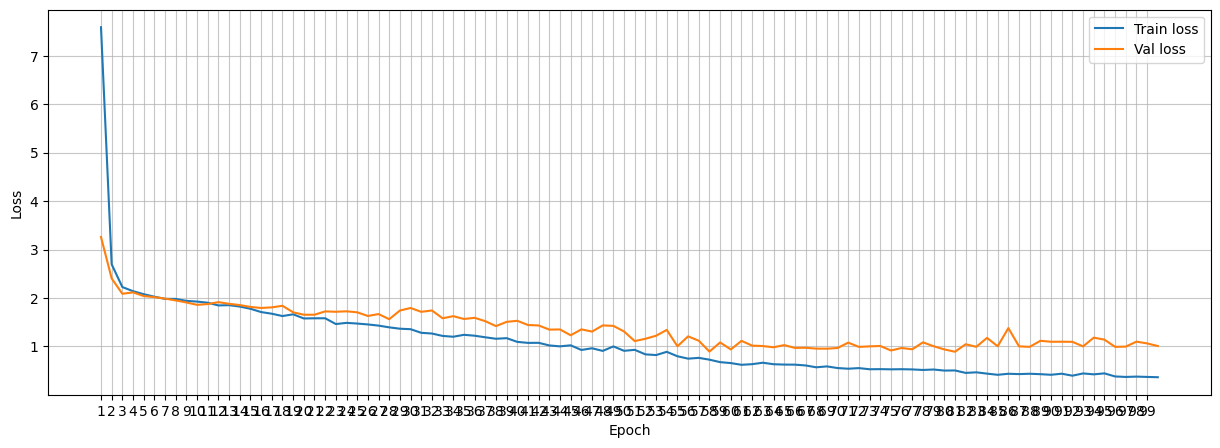

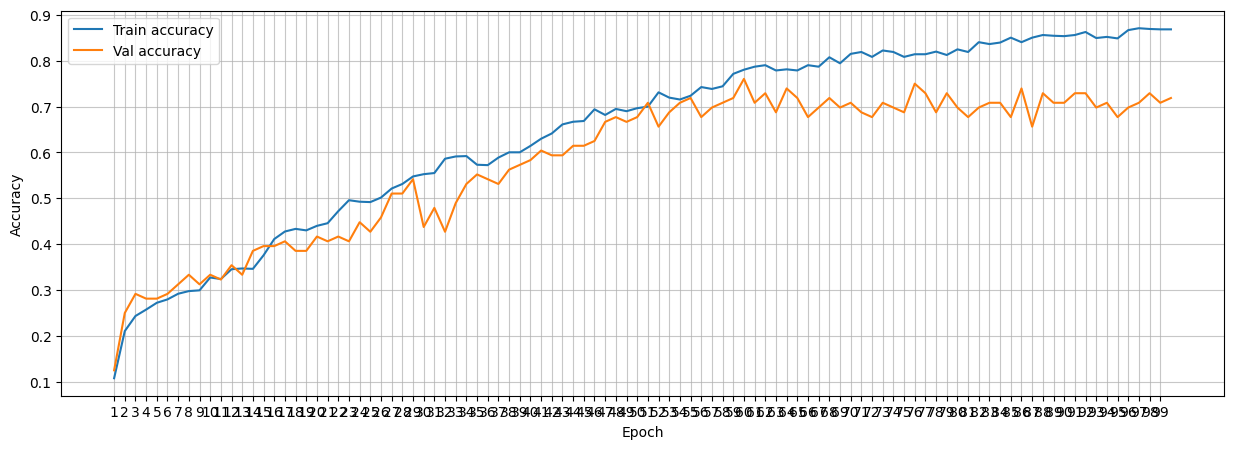

In [ ]:
# Plot loss
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Val loss')
plt.xticks(np.arange(1, len(train_loss)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=.7)
plt.legend()

# Plot accuracy
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train accuracy')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Val accuracy')
plt.xticks(np.arange(1, len(train_acc)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=.7)
plt.legend()
plt.show()

COMPREHENSIVE EVALUATION RESULTS
Accuracy: 0.6875 (68.75%)

MACRO AVERAGES:
  F1-Score   : 0.6880
  Precision  : 0.7406
  Recall     : 0.6875

WEIGHTED AVERAGES:
  F1-Score   : 0.6880
  Precision  : 0.7406
  Recall     : 0.6875

PER-CLASS METRICS:
------------------------------------------------------------
Class           F1       Precision  Recall  
------------------------------------------------------------
chainsaw        0.8571   1.0000     0.7500  
clock_tick      0.4286   0.5000     0.3750  
crackling_fire  0.5455   1.0000     0.3750  
crying_baby     1.0000   1.0000     1.0000  
dog             0.7000   0.5833     0.8750  
helicopter      0.7368   0.6364     0.8750  
rain            0.5000   0.4167     0.6250  
rooster         0.8571   1.0000     0.7500  
sea_waves       0.5882   0.5556     0.6250  
sneezing        0.6667   0.7143     0.6250  

DETAILED CLASSIFICATION REPORT
                precision    recall  f1-score   support

      chainsaw     1.0000    0.7500    0.8571 

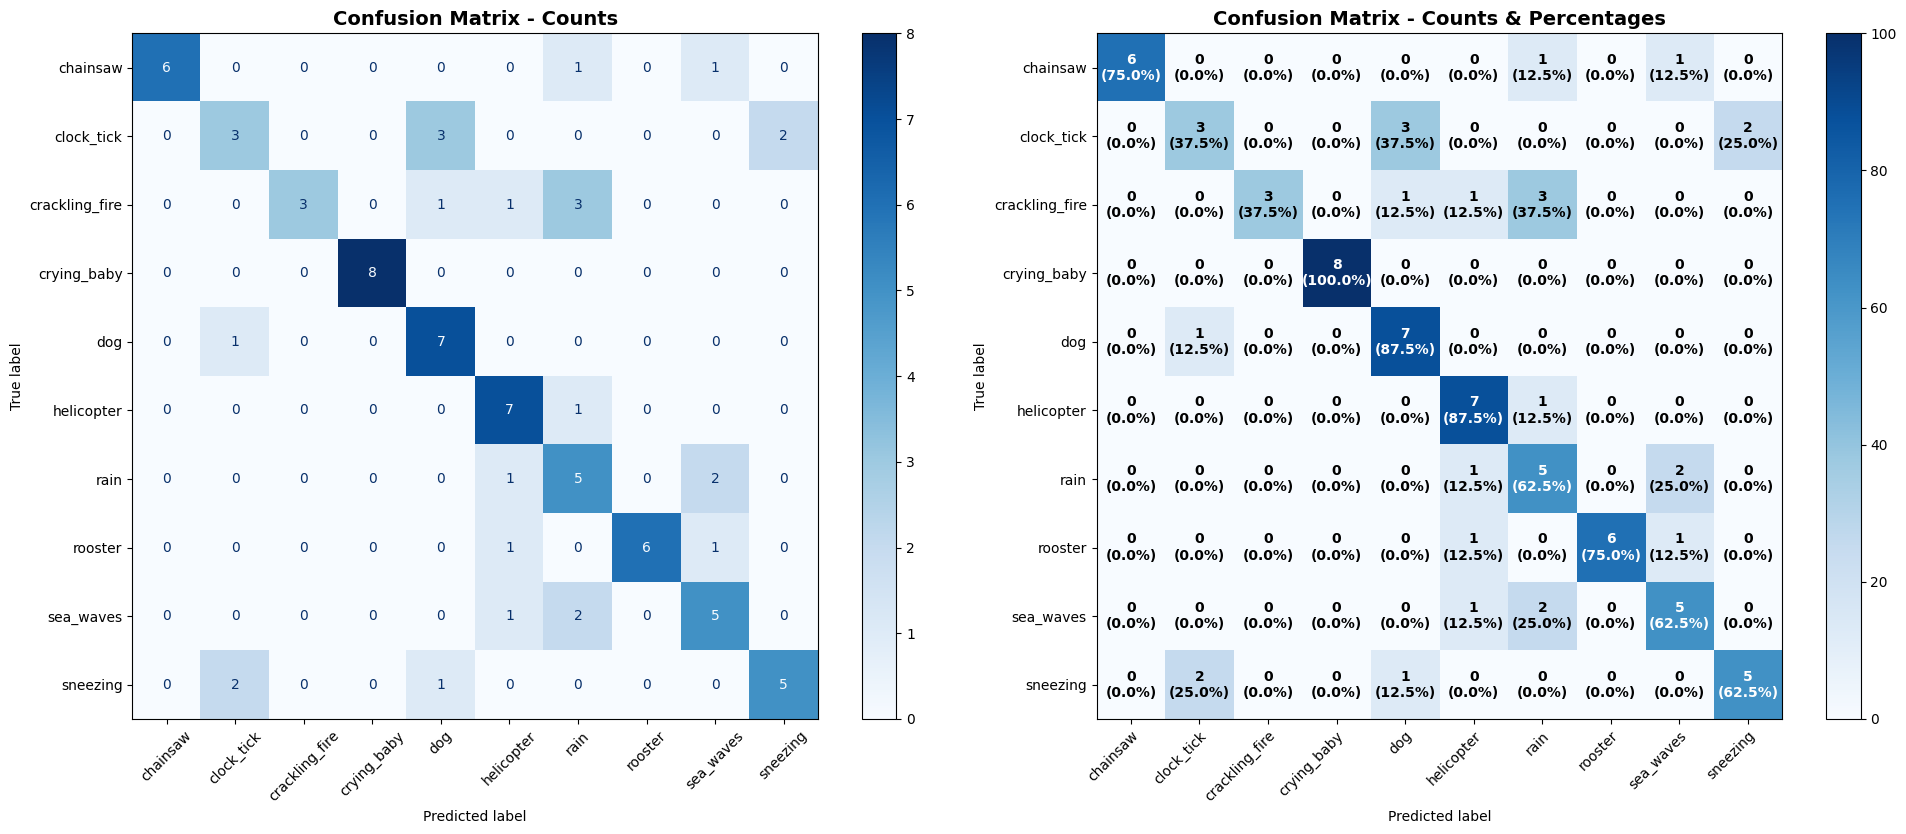


PER-CLASS ACCURACY BREAKDOWN
True Class      Correct  Total    Accuracy  
------------------------------------------------------------
chainsaw        6        8        75.00     %
clock_tick      3        8        37.50     %
crackling_fire  3        8        37.50     %
crying_baby     8        8        100.00    %
dog             7        8        87.50     %
helicopter      7        8        87.50     %
rain            5        8        62.50     %
rooster         6        8        75.00     %
sea_waves       5        8        62.50     %
sneezing        5        8        62.50     %


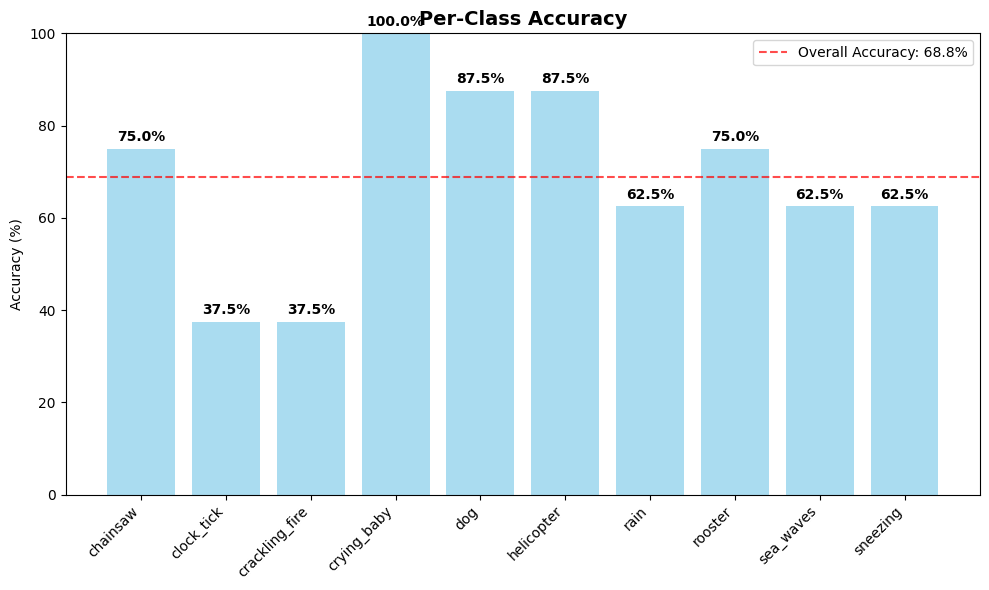

In [ ]:
results_scnn_tae = evaluate_model_comprehensive(tae_c_snn_model, tae_test_loader, ESCLabels.class_names, device)

#Spike Encoding: Step Forward

In [ ]:
sf_train_dataset = StepForwardDataset(X_train_tensor, y_train_tensor)
sf_val_dataset = StepForwardDataset(X_val_tensor, y_val_tensor)
sf_test_dataset = StepForwardDataset(X_test_tensor, y_test_tensor)

In [ ]:
sf_train_loader = DataLoader(sf_train_dataset,batch_size=BATCH_SIZE,shuffle=True,
                             num_workers=2,pin_memory=torch.cuda.is_available())

sf_val_loader = DataLoader(sf_val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                           num_workers=2, pin_memory=torch.cuda.is_available())

sf_test_loader = DataLoader(sf_test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                            num_workers=2, pin_memory=torch.cuda.is_available())

In [ ]:
sf_X_batch, sf_y_batch = next(iter(sf_train_loader))
print("Threshold Adaptive encoding compleated!")

##Step Forward: SNN training

In [ ]:
sf_snn_classifier = SNNClassifier(
    n_mels=N_MELS,
    hidden_sizes=hidden_sizes,
    num_classes=num_classes,
    surr_grad=snn.surrogate.fast_sigmoid(),
    learn_thr=True,
    learn_beta=True
).to(device)

summary(sf_snn_classifier, input_size=(32, 1, N_MELS))

In [ ]:
optimizer = torch.optim.Adam(sf_snn_classifier.parameters(), lr=0.001)

train_loss, train_acc, val_loss, val_acc = train_fn(
    model=sf_snn_classifier,
    train_loader=sf_train_loader,
    valid_loader=sf_val_loader,
    accuracy=SF.acc.accuracy_rate,
    loss_fn=snn.functional.ce_count_loss(),
    optimizer=optimizer,
    epochs=num_epochs,
    patience=patience,
    path="./",
    device=device,
    verbose=True,
)

In [ ]:
torch.save(sf_snn_classifier.state_dict(), '/content/drive/MyDrive/HumanData/best_models/step_forward/sf_snn.pth')

##Step Forward: SNN evaluation

In [ ]:
# Plot loss
plt.figure(figsize=(20,5))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Val loss')
plt.xticks(np.arange(1, len(train_loss)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=.7)
plt.legend()

# Plot accuracy
plt.figure(figsize=(20,5))
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train accuracy')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Val accuracy')
plt.xticks(np.arange(1, len(train_acc)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=.7)
plt.legend()
plt.show()

In [ ]:
results_snn_sf = evaluate_model_comprehensive(sf_snn_classifier, sf_test_loader, ESCLabels.class_names, device)

##Step Forward: SCNN training

In [ ]:
sf_c_snn_model = C_SNN(
    surr_grad=snn.surrogate.fast_sigmoid(),
    n_mels=N_MELS,
    num_classes=10,
    conv_channels1=8,
    dropout_rate=0.0,
    kernel_size=3,
    pool_kernel=2
).to(device)

summary(sf_c_snn_model, input_size=(BATCH_SIZE, 1, N_MELS))

In [ ]:
optimizer = torch.optim.Adam(sf_c_snn_model.parameters(), lr=0.0001)

train_loss, train_acc, val_loss, val_acc = train_fn(
    model=sf_c_snn_model,
    train_loader=sf_train_loader,
    valid_loader=sf_val_loader,
    accuracy=SF.acc.accuracy_rate,
    loss_fn=snn.functional.ce_count_loss(),
    optimizer=optimizer,
    epochs=num_epochs,
    patience=patience,
    path="./",
    verbose=True,
)

In [ ]:
torch.save(sf_c_snn_model.state_dict(), '/content/drive/MyDrive/HumanData/best_models/step_forward/sf_scnn.pth')

##Step Forward: SCNN evaluation

In [ ]:
# Plot loss
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Val loss')
plt.xticks(np.arange(1, len(train_loss)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=.7)
plt.legend()

# Plot accuracy
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train accuracy')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Val accuracy')
plt.xticks(np.arange(1, len(train_acc)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=.7)
plt.legend()
plt.show()

In [ ]:
results_scnn_sf = evaluate_model_comprehensive(sf_c_snn_model, sf_test_loader, ESCLabels.class_names, device)

# Performance Analysis

### Delta Modulation SNN

In [ ]:
analysis_delta_snn = run_performance_evaluation(
    model=delta_snn_classifier,
    train_loader=delta_train_loader,
    val_loader=delta_val_loader,
    test_loader=delta_test_loader,
    device=device
)

###Delta Modulation SCNN

In [ ]:
analysis_delta_scnn = run_performance_evaluation(
    model=delta_c_snn_model,
    train_loader=delta_train_loader,
    val_loader=delta_val_loader,
    test_loader=delta_test_loader,
    device=device
)

###TAE SNN

In [ ]:
analysis_tae_snn = run_performance_evaluation(
    model=tae_snn_classifier,
    train_loader=tae_train_loader,
    val_loader=tae_val_loader,
    test_loader=tae_test_loader,
    device=device
)

###TAE SCNN

In [ ]:
analysis_tae_scnn = run_performance_evaluation(
    model=tae_c_snn_model,
    train_loader=tae_train_loader,
    val_loader=tae_val_loader,
    test_loader=tae_test_loader,
    device=device
)

###Step Forward SNN

In [ ]:
analysis_sf_snn = run_performance_evaluation(
    model=sf_snn_classifier,
    train_loader=sf_train_loader,
    val_loader=sf_val_loader,
    test_loader=sf_test_loader,
    device=device
)

###Step Forward SCNN

In [ ]:
analysis_sf_scnn = run_performance_evaluation(
    model=sf_c_snn_model,
    train_loader=sf_train_loader,
    val_loader=sf_val_loader,
    test_loader=sf_test_loader,
    device=device
)